In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio
import nibabel as nib

In [14]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 141]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask


In [15]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="BraTS_2023_train/t1cSliced", t2f_dir="BraTS_2023_train/t2fSliced", seg_dir="BraTS_2023_train/segSliced", transforms=data_transforms)


In [16]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [17]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


63531
3971
Data shape: torch.Size([16, 2, 256, 256])
Labels shape: torch.Size([16, 256, 256])
Data shape: torch.Size([16, 2, 256, 256])
Labels shape: torch.Size([16, 256, 256])


In [18]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = self.double_conv(512, 1024)
        self.pool5 = nn.MaxPool2d(2)

        # Bottom
        self.conv6 = self.double_conv(1024, 2048)

        # Upsample path
        self.up7 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(2048, 1024)
        self.up8 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(1024, 512)
        self.up9 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(512, 256)
        self.up10 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv10 = self.double_conv(256, 128)
        self.up11 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv11 = self.double_conv(128, 64)

        # Output
        self.conv12 = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        p5 = self.pool5(c5)

        # Bottom
        c6 = self.conv6(p5)

        # Upsample path
        up7 = self.up7(c6)
        merge7 = torch.cat([up7, c5], dim=1)
        c7 = self.conv7(merge7)
        up8 = self.up8(c7)
        merge8 = torch.cat([up8, c4], dim=1)
        c8 = self.conv8(merge8)
        up9 = self.up9(c8)
        merge9 = torch.cat([up9, c3], dim=1)
        c9 = self.conv9(merge9)
        up10 = self.up10(c9)
        merge10 = torch.cat([up10, c2], dim=1)
        c10 = self.conv10(merge10)
        up11 = self.up11(c10)
        merge11 = torch.cat([up11, c1], dim=1)
        c11 = self.conv11(merge11)

        # Output
        out = self.conv12(c11)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [19]:
def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()


In [20]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)

In [21]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_model_1.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2, out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_model_1.pth")

    
    return model

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


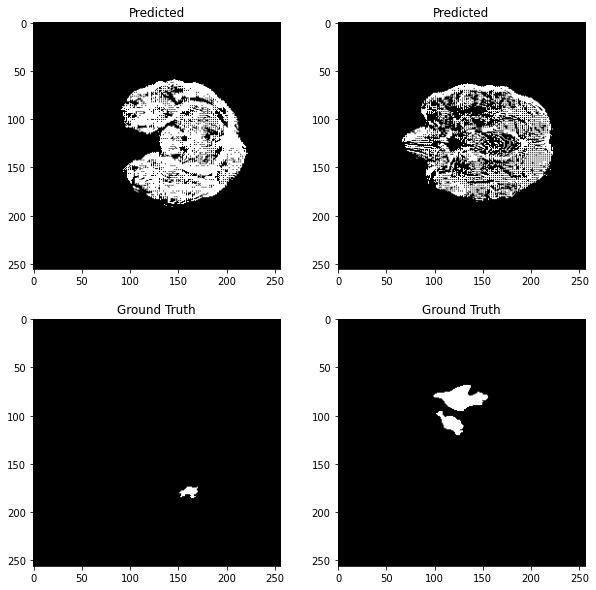

100%|██████████| 3971/3971 [36:28<00:00,  1.81it/s]



Average Training Loss: 0.04579689018981819

Average Training DSC: [0.99112155 0.63682287 0.49644684 0.44201157]
Average Training ASSD: [  2.81526215  89.35810731 102.83850947  84.24514847]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


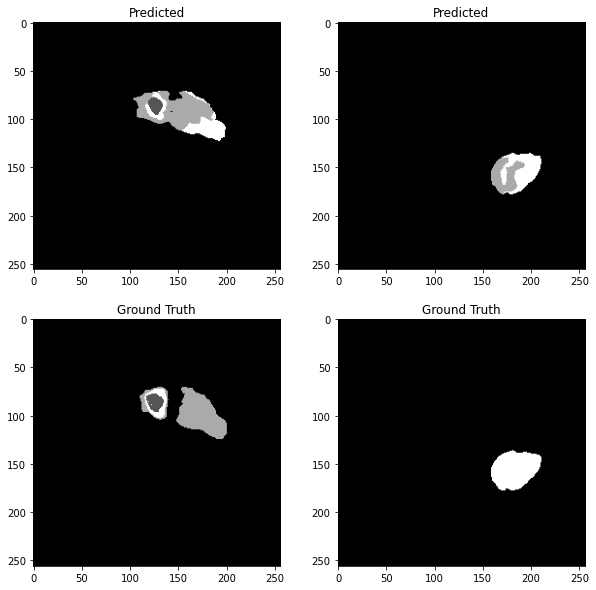

100%|██████████| 993/993 [05:55<00:00,  2.79it/s]


Average Validation Loss: 0.025127236268033853

Average Validation DSC: [0.99704339 0.7547188  0.67787956 0.64605998]
Average Validation ASSD: [ 0.61560316 40.03780403 52.84271966 10.62383559]
Epoch 2/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


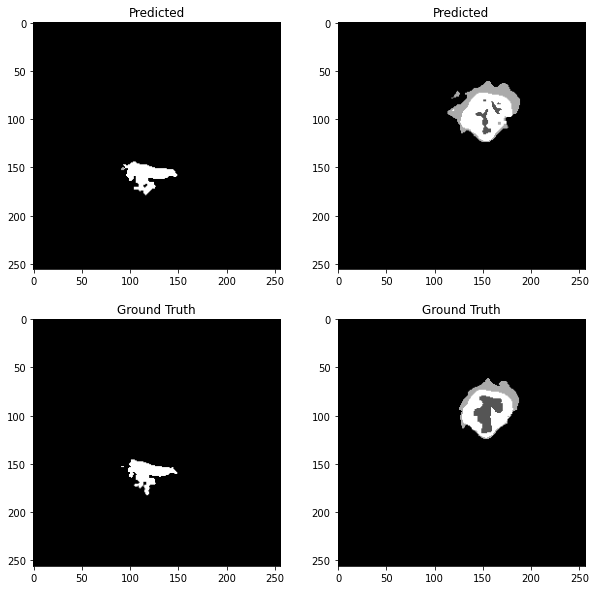

100%|██████████| 3971/3971 [37:37<00:00,  1.76it/s]



Average Training Loss: 0.01979682994377899

Average Training DSC: [0.99773144 0.76241368 0.71765974 0.66258898]
Average Training ASSD: [ 0.46147156 39.57391603 45.97253568 24.188898  ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


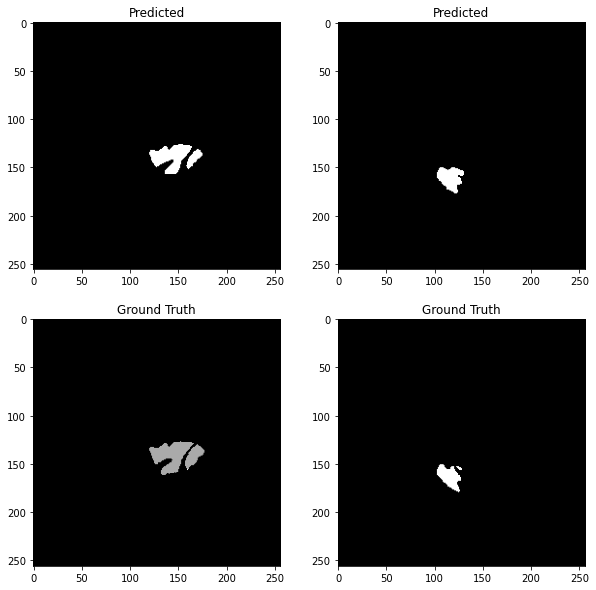

100%|██████████| 993/993 [05:50<00:00,  2.83it/s]


Average Validation Loss: 0.01927363878905713

Average Validation DSC: [0.99781789 0.7850887  0.76549469 0.66856324]
Average Validation ASSD: [ 0.48702265 34.89881171 34.16078748 32.049758  ]
Epoch 3/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


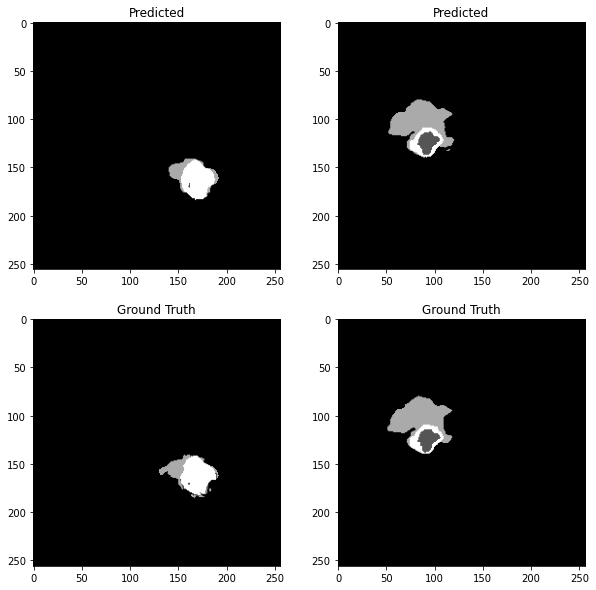

100%|██████████| 3971/3971 [37:51<00:00,  1.75it/s]



Average Training Loss: 0.01577944351989683

Average Training DSC: [0.99811871 0.79567285 0.77944409 0.70653784]
Average Training ASSD: [ 0.3598353  33.4564578  32.57760922 20.56761176]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


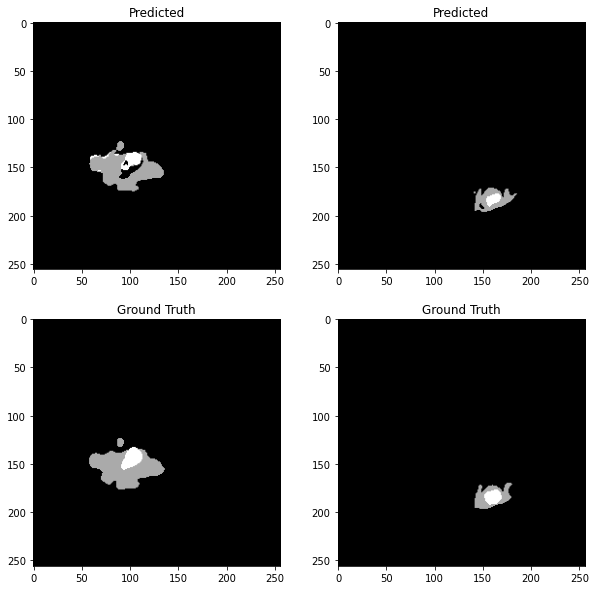

100%|██████████| 993/993 [05:52<00:00,  2.82it/s]


Average Validation Loss: 0.013983046149690556

Average Validation DSC: [0.99824828 0.81801821 0.80431829 0.72726082]
Average Validation ASSD: [ 0.32558287 29.30087272 24.32276753 17.56206833]
Epoch 4/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


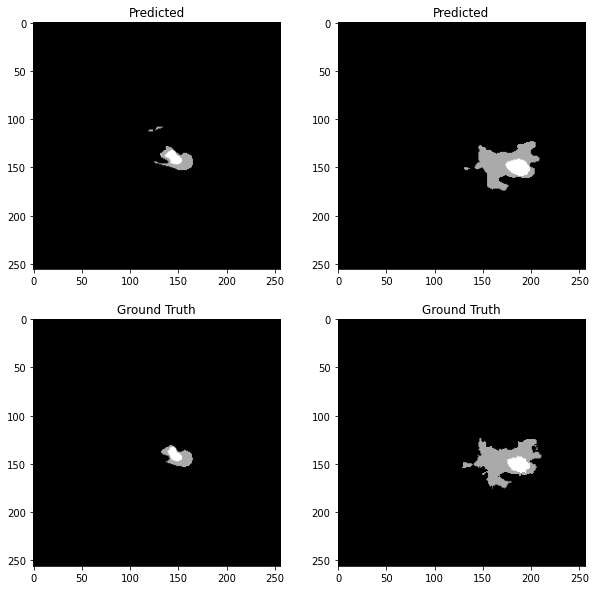

100%|██████████| 3971/3971 [37:44<00:00,  1.75it/s]



Average Training Loss: 0.013182196107457782

Average Training DSC: [0.99838009 0.8192208  0.8135717  0.73376668]
Average Training ASSD: [ 0.2997106  29.14340035 25.8140514  19.04758353]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


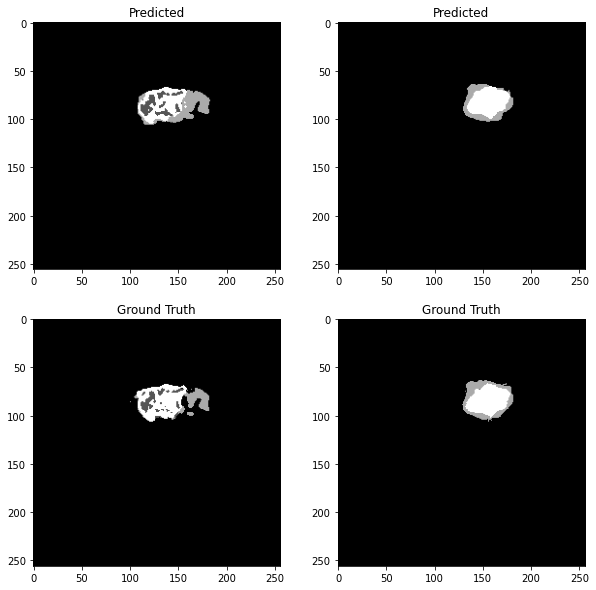

100%|██████████| 993/993 [05:51<00:00,  2.82it/s]


Average Validation Loss: 0.011811639699045745

Average Validation DSC: [0.99853266 0.82815113 0.83777739 0.7536999 ]
Average Validation ASSD: [ 0.26135872 27.10901928 20.32160439 16.37430189]
Epoch 5/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


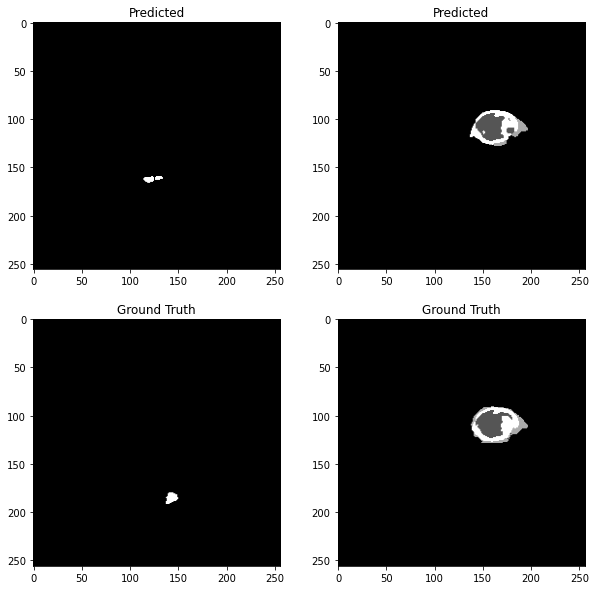

100%|██████████| 3971/3971 [37:36<00:00,  1.76it/s]



Average Training Loss: 0.011419569575693341

Average Training DSC: [0.99858371 0.83357759 0.83744799 0.75547717]
Average Training ASSD: [ 0.25437431 26.66101186 21.37637616 17.92822492]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


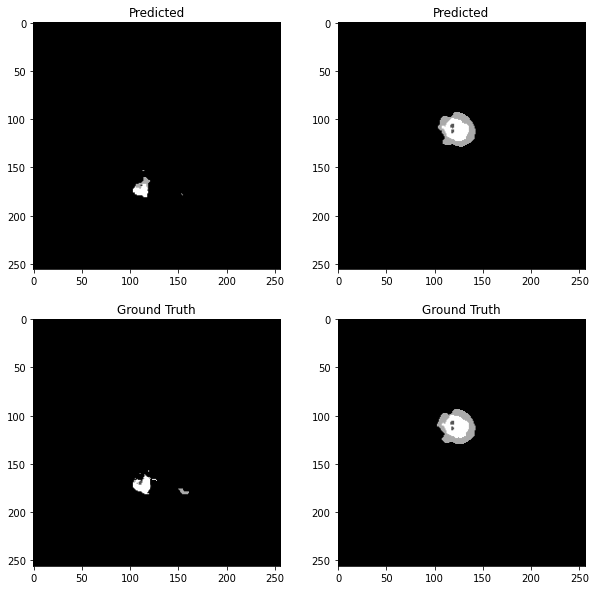

100%|██████████| 993/993 [05:50<00:00,  2.84it/s]


Average Validation Loss: 0.010795027668956453

Average Validation DSC: [0.99865383 0.84172866 0.84969858 0.76125814]
Average Validation ASSD: [ 0.24079941 24.87707921 18.33316047 18.67908586]
Epoch 6/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


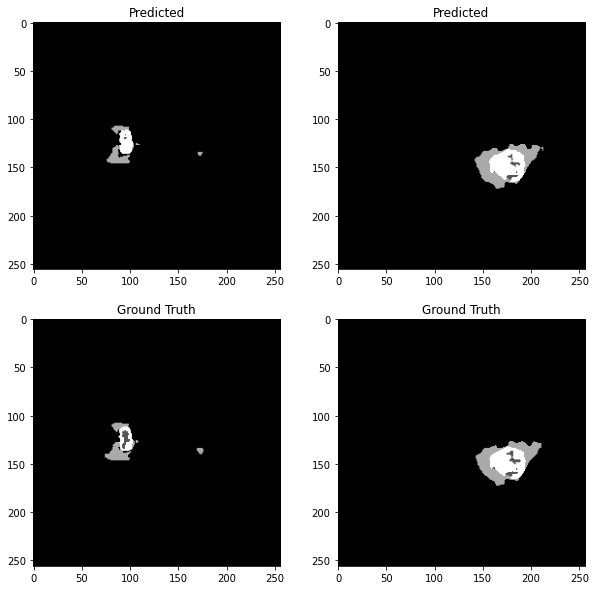

100%|██████████| 3971/3971 [38:07<00:00,  1.74it/s]



Average Training Loss: 0.010008081522550002

Average Training DSC: [0.99873441 0.84581667 0.8559307  0.77276138]
Average Training ASSD: [ 0.2193627  24.56032404 18.12015226 16.65736499]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


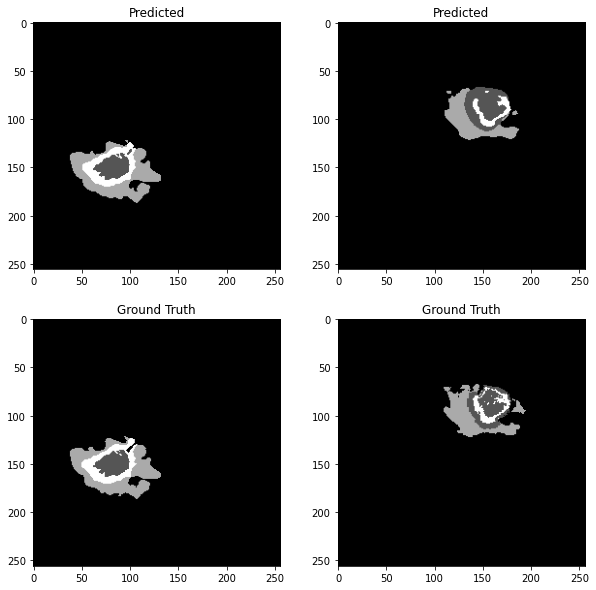

100%|██████████| 993/993 [05:53<00:00,  2.81it/s]


Average Validation Loss: 0.01005565760467738

Average Validation DSC: [0.99874902 0.85357137 0.85613551 0.76437985]
Average Validation ASSD: [ 0.22837647 23.2696038  18.98105933 19.83170594]
Epoch 7/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


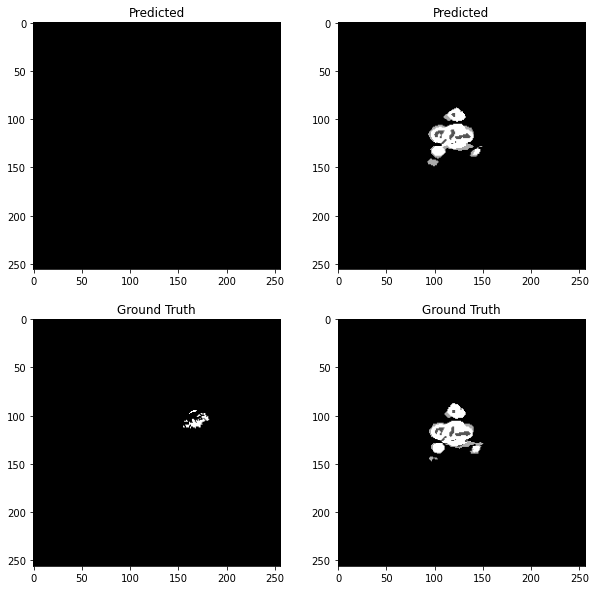

100%|██████████| 3971/3971 [37:36<00:00,  1.76it/s]



Average Training Loss: 0.009120691427878906

Average Training DSC: [0.99883529 0.85411482 0.86739999 0.78646951]
Average Training ASSD: [ 0.19550141 23.26810445 16.10966532 15.78543613]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


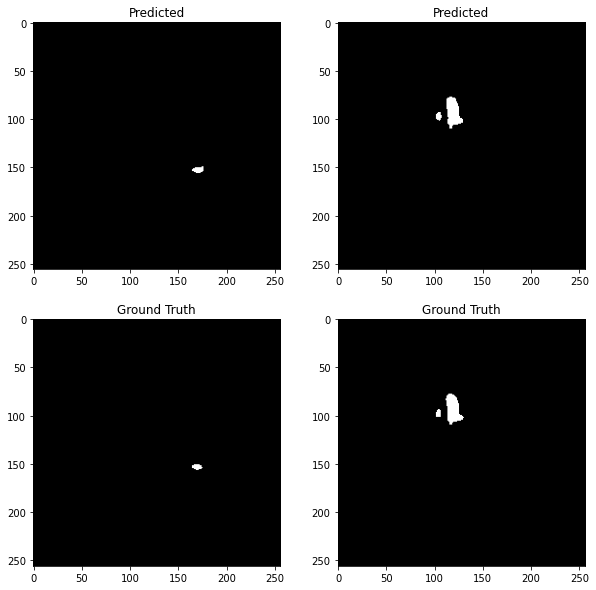

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.009183939651859041

Average Validation DSC: [0.99884893 0.85364575 0.86338305 0.79077312]
Average Validation ASSD: [ 0.18131694 23.10415816 18.42832678 12.40118454]
Epoch 8/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


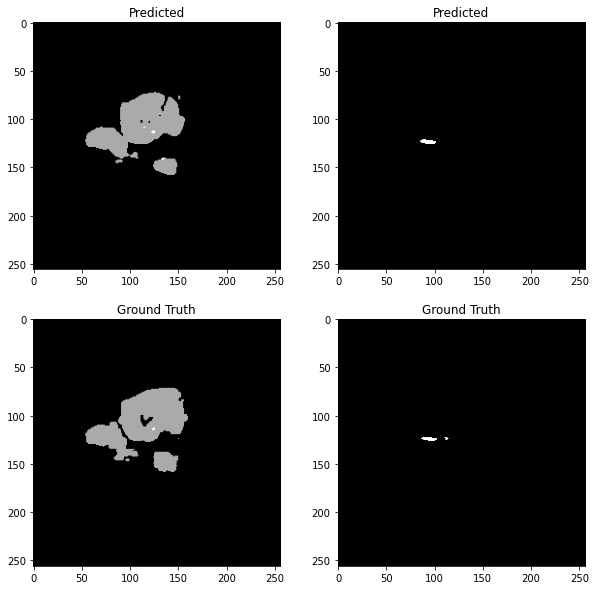

100%|██████████| 3971/3971 [36:56<00:00,  1.79it/s]



Average Training Loss: 0.008315419172551516

Average Training DSC: [0.99892305 0.86245458 0.87942213 0.79958688]
Average Training ASSD: [ 0.17320235 21.67242272 14.06064687 14.73677099]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


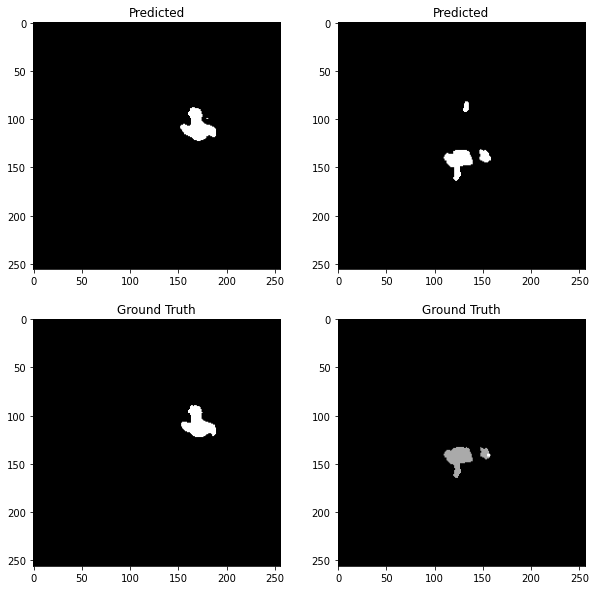

100%|██████████| 993/993 [05:54<00:00,  2.80it/s]


Average Validation Loss: 0.008500293514823535

Average Validation DSC: [0.99890278 0.86224575 0.87330579 0.79752672]
Average Validation ASSD: [ 0.17942157 21.32634312 15.32305734 14.94343697]
Epoch 9/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


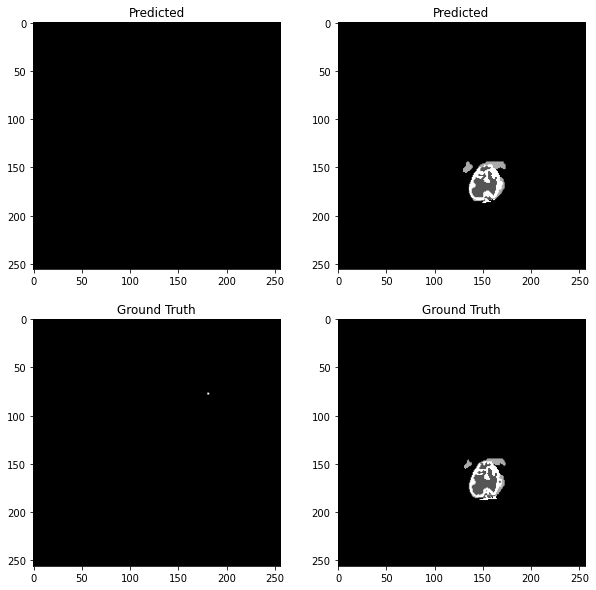

100%|██████████| 3971/3971 [37:47<00:00,  1.75it/s]



Average Training Loss: 0.007657832345341055

Average Training DSC: [0.99899166 0.87032714 0.88688602 0.80962468]
Average Training ASSD: [ 0.15817008 19.94356421 12.98353608 14.39636999]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


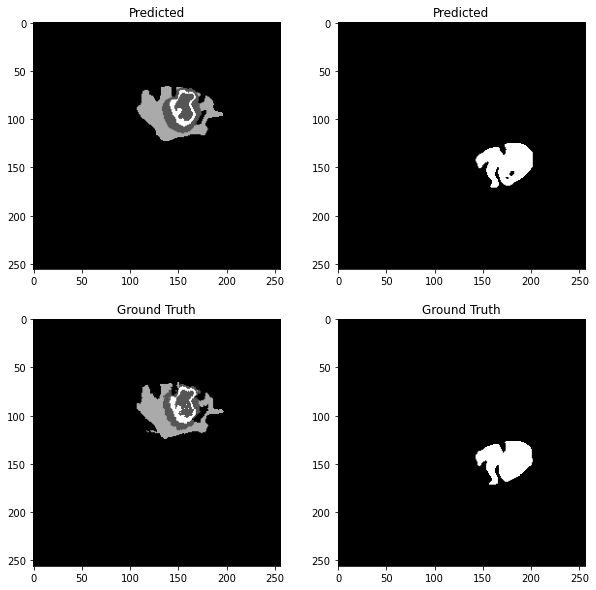

100%|██████████| 993/993 [05:54<00:00,  2.80it/s]


Average Validation Loss: 0.008063994747589362

Average Validation DSC: [0.9989742  0.86700998 0.88091598 0.80263215]
Average Validation ASSD: [ 0.16964945 20.46543293 14.49409425 15.20019264]
Epoch 10/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


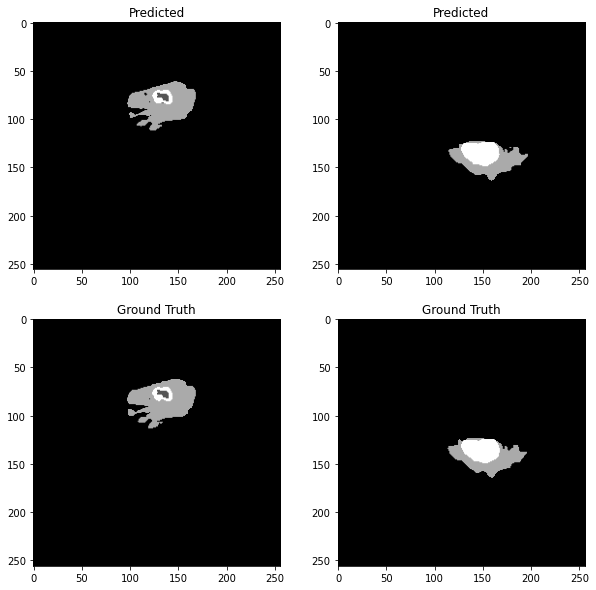

100%|██████████| 3971/3971 [37:31<00:00,  1.76it/s]



Average Training Loss: 0.0071919666437511446

Average Training DSC: [0.99904792 0.87548172 0.89524939 0.81830598]
Average Training ASSD: [ 0.14604491 18.83847666 11.36838008 13.84445144]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


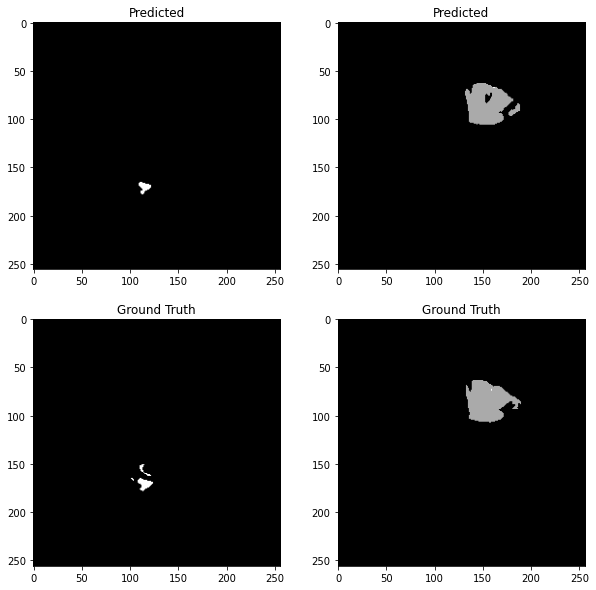

100%|██████████| 993/993 [05:40<00:00,  2.92it/s]


Average Validation Loss: 0.008438119249303955

Average Validation DSC: [0.99896179 0.8722049  0.86093559 0.79500592]
Average Validation ASSD: [ 0.16828222 19.80624507 22.13807275 16.87102393]
Epoch 11/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


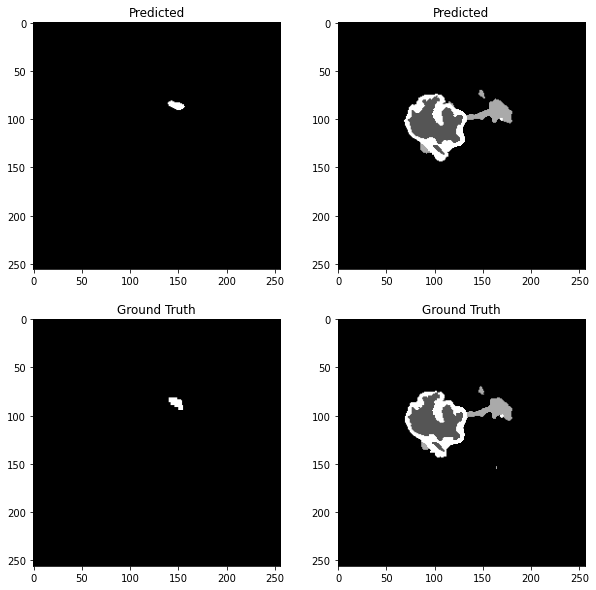

100%|██████████| 3971/3971 [36:43<00:00,  1.80it/s]



Average Training Loss: 0.006771558693717312

Average Training DSC: [0.99909055 0.88032568 0.90053544 0.82609751]
Average Training ASSD: [ 0.13705239 17.88577132 10.44032054 13.17205399]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


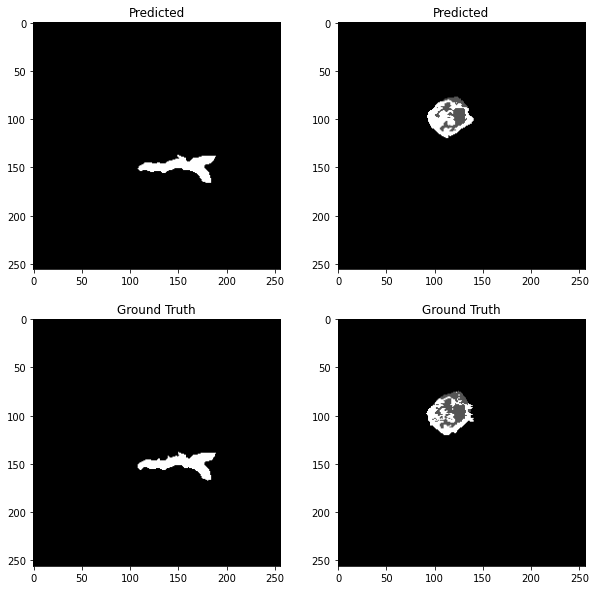

100%|██████████| 993/993 [05:50<00:00,  2.84it/s]


Average Validation Loss: 0.007887332729501921

Average Validation DSC: [0.999034   0.8804248  0.88804793 0.80480388]
Average Validation ASSD: [ 0.16508841 18.19940797 13.04171528 16.56211623]
Epoch 12/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


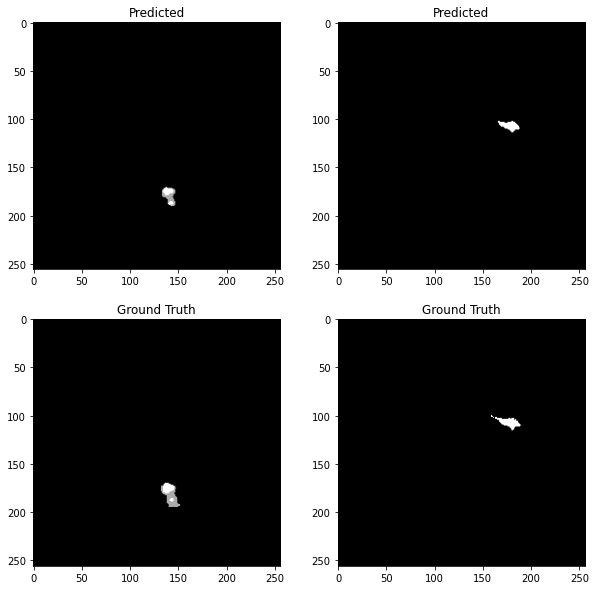

100%|██████████| 3971/3971 [37:29<00:00,  1.77it/s]



Average Training Loss: 0.00634120350139081

Average Training DSC: [0.99914374 0.88619298 0.90676784 0.83443566]
Average Training ASSD: [ 0.12607622 16.51477142  9.48979571 12.6610868 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


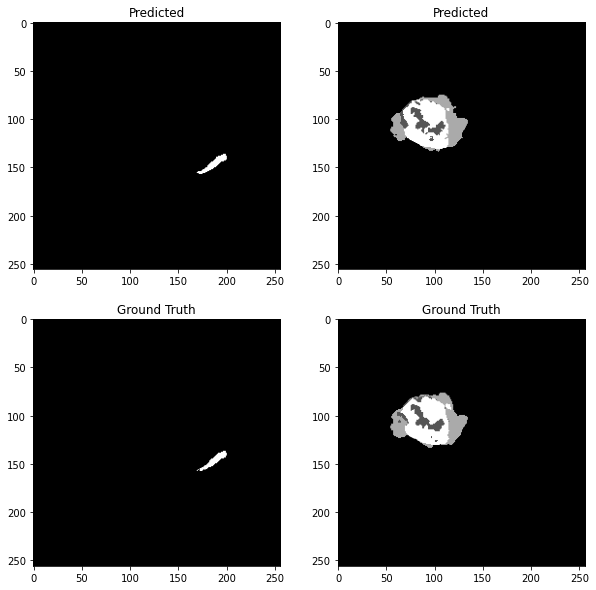

100%|██████████| 993/993 [05:51<00:00,  2.83it/s]


Average Validation Loss: 0.007806260782375571

Average Validation DSC: [0.99904697 0.87596797 0.88717236 0.81695204]
Average Validation ASSD: [ 0.14404615 18.4165425  14.05257843 11.94050796]
Epoch 13/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


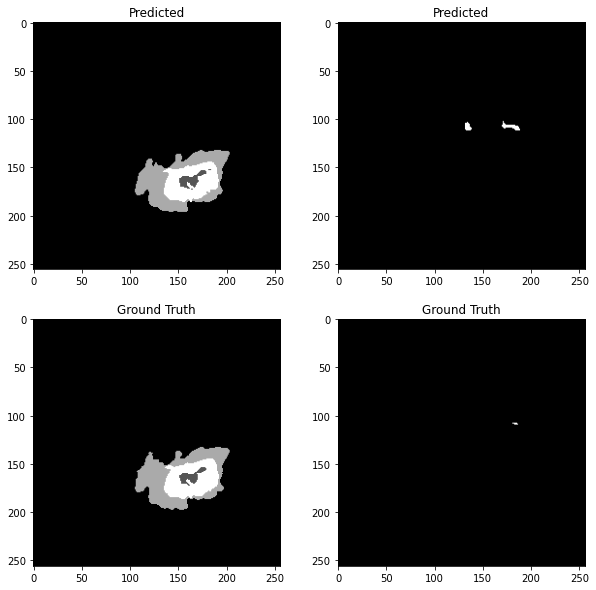

100%|██████████| 3971/3971 [37:54<00:00,  1.75it/s]



Average Training Loss: 0.006063903810632762

Average Training DSC: [0.99917463 0.89007009 0.91170747 0.84062421]
Average Training ASSD: [ 0.11865331 15.73113467  8.50868145 12.08215368]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


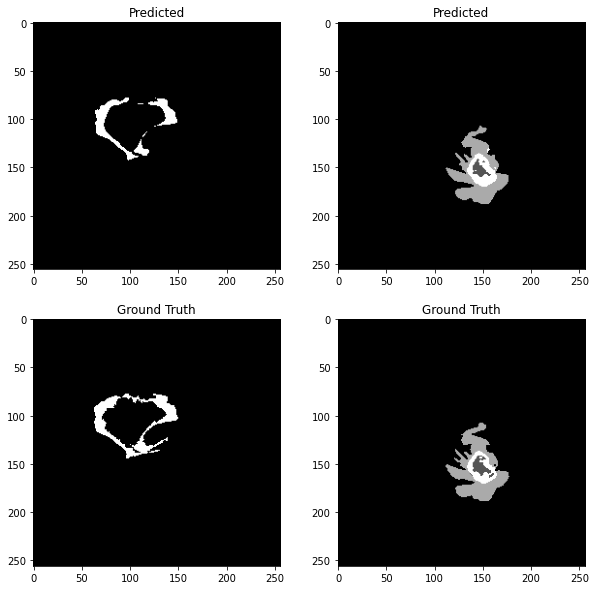

100%|██████████| 993/993 [05:47<00:00,  2.86it/s]


Average Validation Loss: 0.00733593419641594

Average Validation DSC: [0.99909001 0.88043062 0.88843573 0.81889159]
Average Validation ASSD: [ 0.14366615 17.93581797 14.74731743 12.92393987]
Epoch 14/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


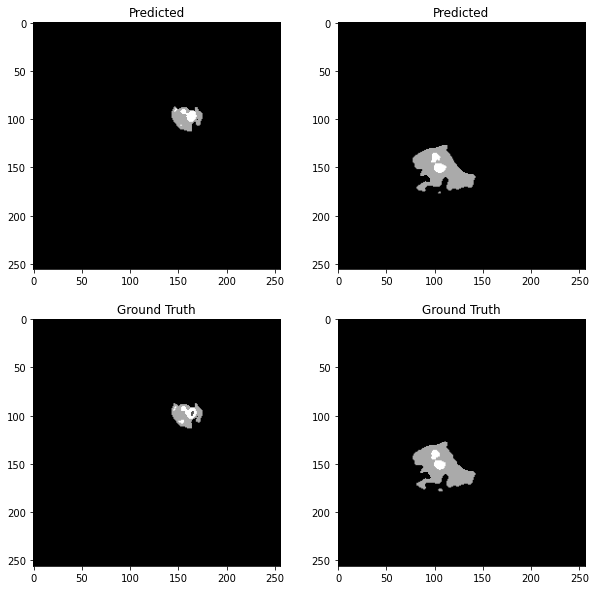

100%|██████████| 3971/3971 [36:41<00:00,  1.80it/s]



Average Training Loss: 0.005797734912740523

Average Training DSC: [0.99920734 0.89299312 0.9160822  0.84632099]
Average Training ASSD: [ 0.11221068 15.37323592  7.83799222 11.44321257]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


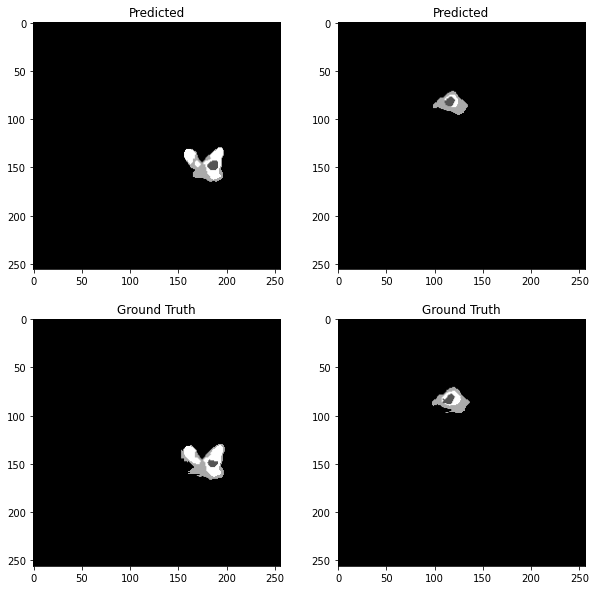

100%|██████████| 993/993 [05:50<00:00,  2.83it/s]


Average Validation Loss: 0.007171314098325456

Average Validation DSC: [0.99911594 0.88234999 0.89408494 0.82530996]
Average Validation ASSD: [ 0.13196122 16.83852604 13.32227547 11.66977166]
Epoch 15/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


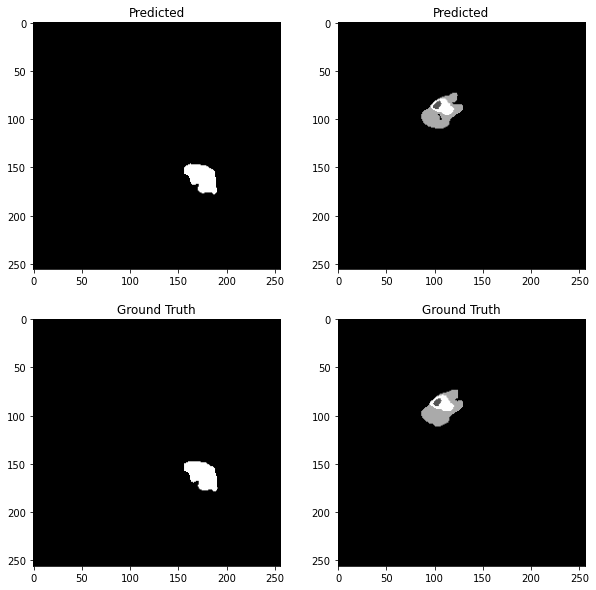

100%|██████████| 3971/3971 [38:04<00:00,  1.74it/s]



Average Training Loss: 0.005520512405780592

Average Training DSC: [0.99923748 0.89788772 0.92020355 0.85171918]
Average Training ASSD: [ 0.10738261 13.95975424  7.27186915 11.25879223]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


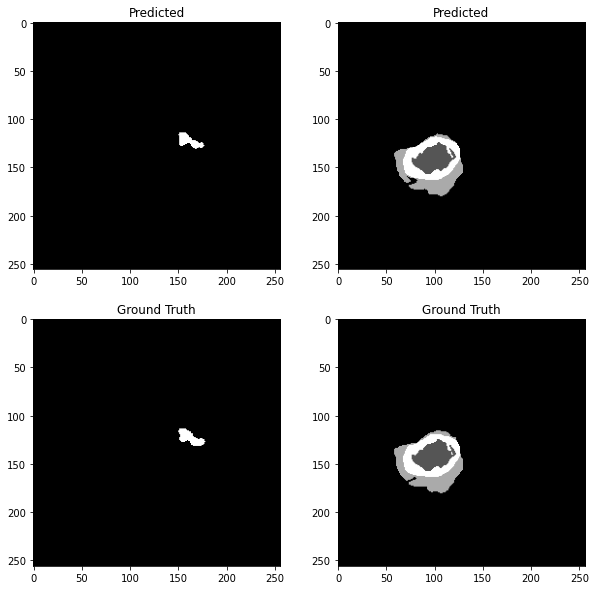

100%|██████████| 993/993 [05:45<00:00,  2.88it/s]


Average Validation Loss: 0.007227643367188184

Average Validation DSC: [0.99907279 0.88816244 0.88816109 0.8242256 ]
Average Validation ASSD: [ 0.14122818 16.94738562 14.09184727 12.12934104]
Epoch 16/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


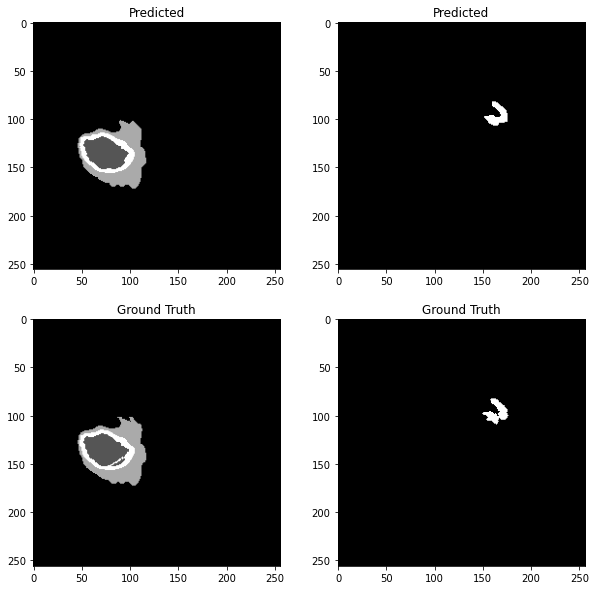

100%|██████████| 3971/3971 [37:32<00:00,  1.76it/s]



Average Training Loss: 0.005337714427742977

Average Training DSC: [0.99926048 0.9005235  0.92268045 0.85532017]
Average Training ASSD: [ 0.10308558 13.4648024   6.90698341 11.25973089]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


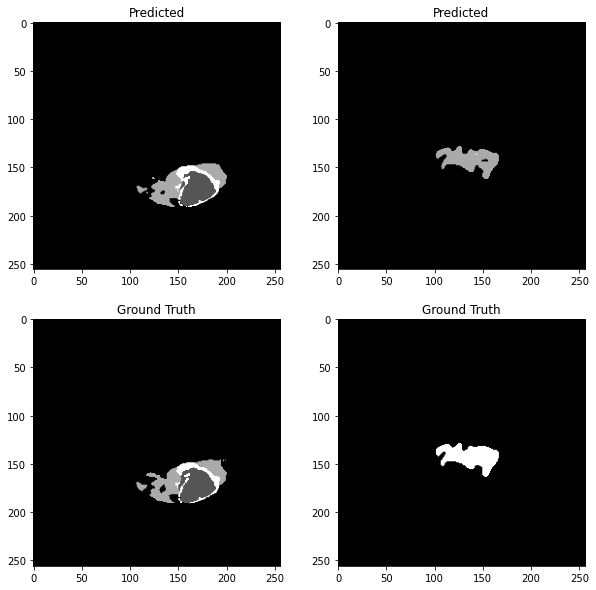

100%|██████████| 993/993 [05:36<00:00,  2.95it/s]


Average Validation Loss: 0.007527882655546039

Average Validation DSC: [0.99911381 0.88675711 0.88406233 0.83050676]
Average Validation ASSD: [ 0.12579731 17.0049223  16.65485845 10.45997107]
Epoch 17/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


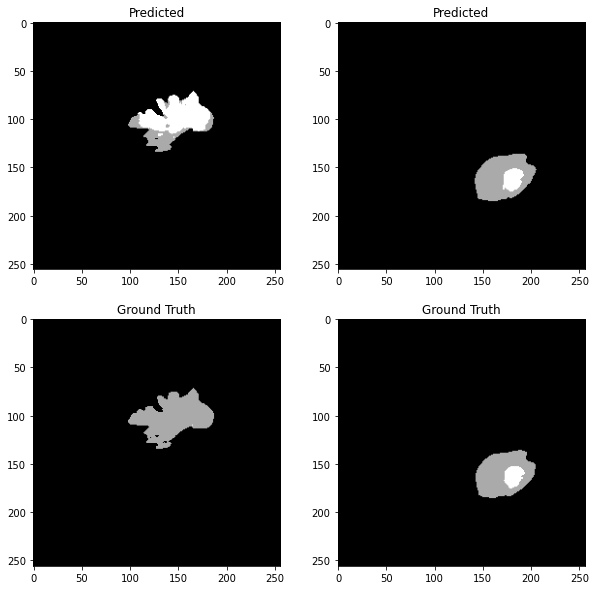

100%|██████████| 3971/3971 [36:49<00:00,  1.80it/s]



Average Training Loss: 0.005180680792702742

Average Training DSC: [0.99928131 0.90207487 0.92530386 0.85917706]
Average Training ASSD: [ 0.09954056 13.21838271  6.34103521 10.76658031]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


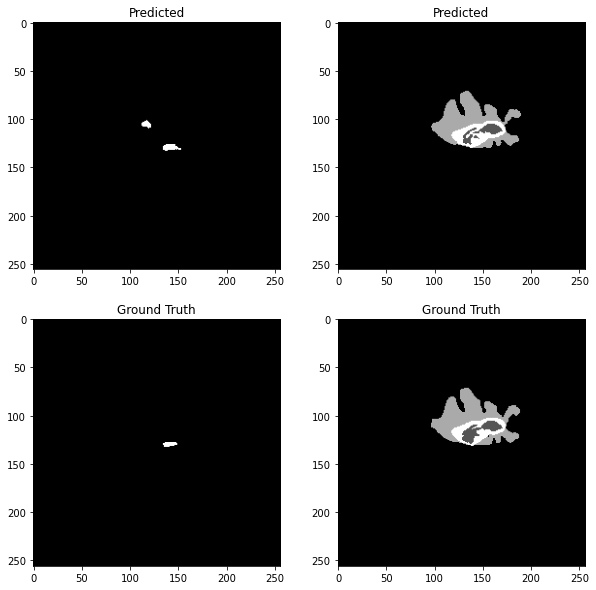

100%|██████████| 993/993 [05:38<00:00,  2.93it/s]


Average Validation Loss: 0.006770463909603063

Average Validation DSC: [0.9991873  0.8888836  0.90088962 0.83875795]
Average Validation ASSD: [ 0.11556065 15.92607522 12.63829464  9.89088042]
Epoch 18/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


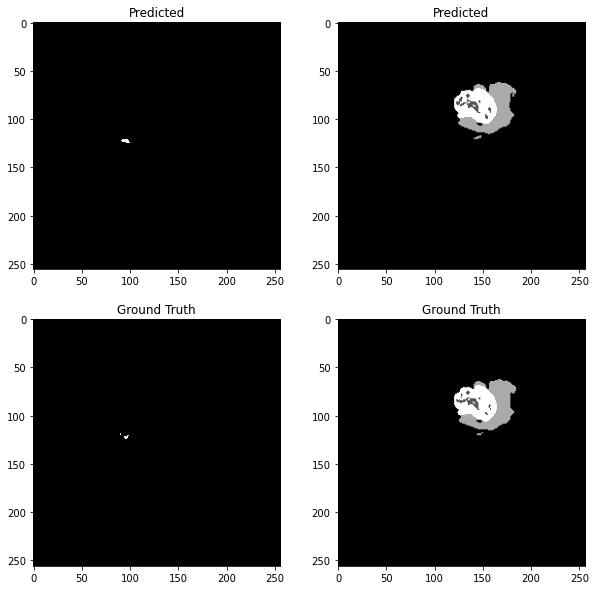

100%|██████████| 3971/3971 [36:44<00:00,  1.80it/s]



Average Training Loss: 0.004987034999273644

Average Training DSC: [0.99930366 0.9054579  0.92761606 0.86306435]
Average Training ASSD: [ 0.09493355 12.47708435  6.06994476 10.45581443]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


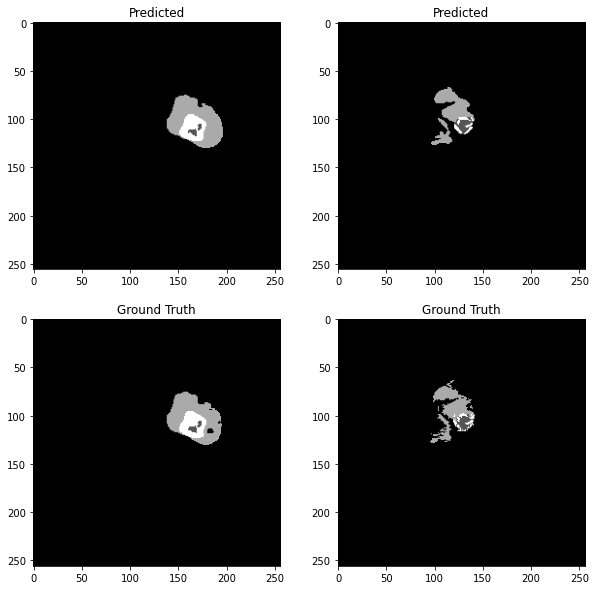

100%|██████████| 993/993 [05:53<00:00,  2.81it/s]


Average Validation Loss: 0.006795505037595033

Average Validation DSC: [0.99916975 0.89555803 0.90277752 0.83947713]
Average Validation ASSD: [ 0.11620706 14.98491898 12.64914274  9.25543721]
Epoch 19/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


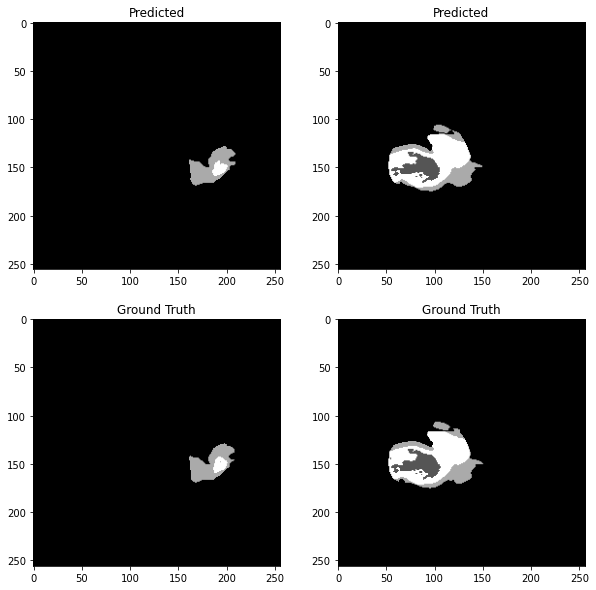

100%|██████████| 3971/3971 [38:02<00:00,  1.74it/s]



Average Training Loss: 0.004825994277734603

Average Training DSC: [0.99932424 0.90714534 0.93060652 0.86718837]
Average Training ASSD: [ 0.0906967  12.23515609  5.67805045  9.91141901]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


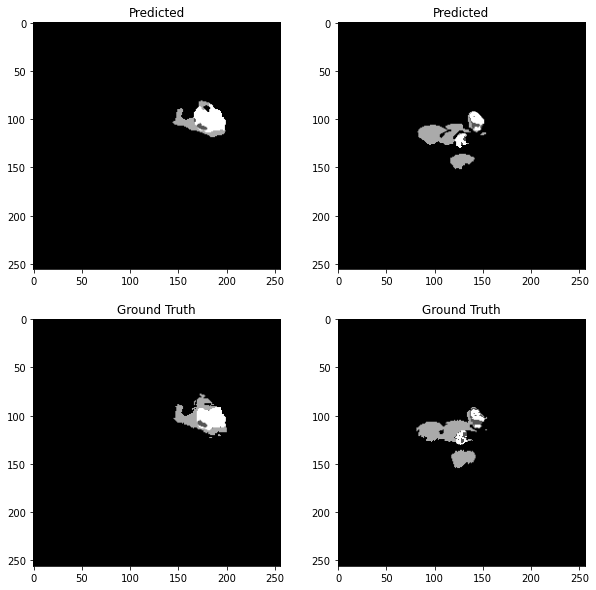

100%|██████████| 993/993 [05:47<00:00,  2.86it/s]


Average Validation Loss: 0.006812996704887302

Average Validation DSC: [0.99917144 0.89216436 0.89987881 0.83963692]
Average Validation ASSD: [ 0.11769607 15.29252763 12.60283408  8.91493141]
Epoch 20/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


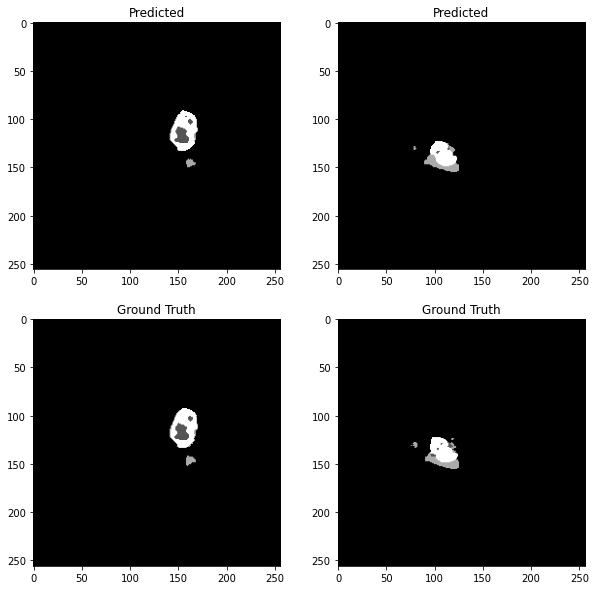

100%|██████████| 3971/3971 [37:27<00:00,  1.77it/s]



Average Training Loss: 0.004650706185970303

Average Training DSC: [0.99934577 0.90932866 0.93411494 0.87126458]
Average Training ASSD: [ 0.08720245 11.71058701  4.96611012  9.68675265]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


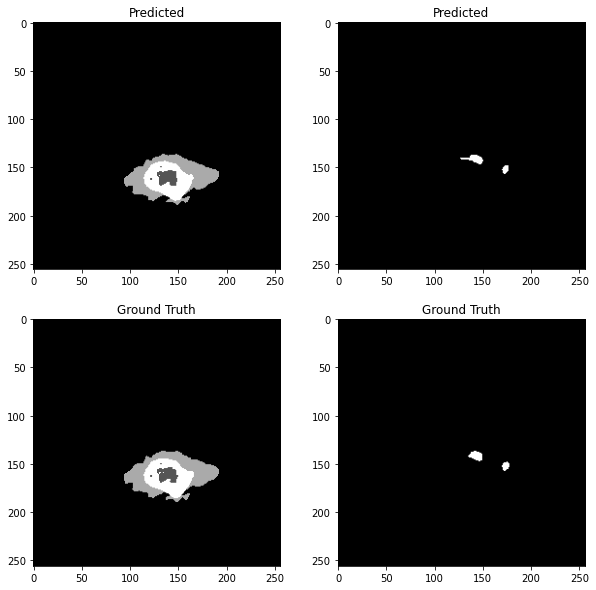

100%|██████████| 993/993 [05:49<00:00,  2.84it/s]


Average Validation Loss: 0.0067533802933717095

Average Validation DSC: [0.99918603 0.89353201 0.901695   0.8416599 ]
Average Validation ASSD: [ 0.11674545 15.22398434 12.41242343  8.34231085]
Epoch 21/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


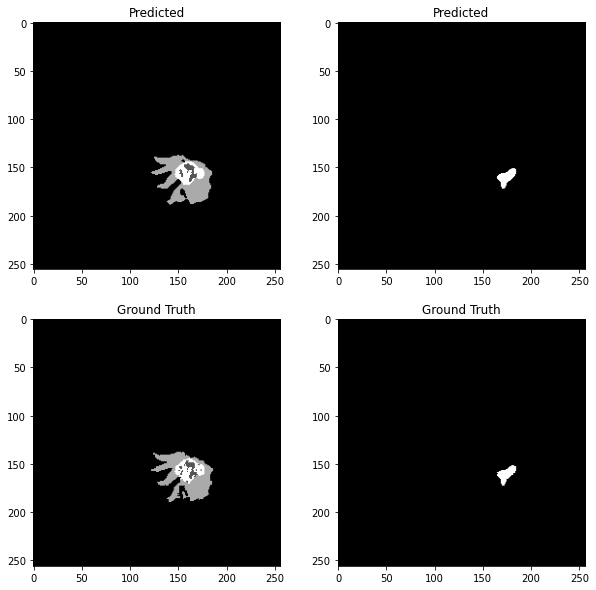

100%|██████████| 3971/3971 [37:00<00:00,  1.79it/s]



Average Training Loss: 0.004531614384192948

Average Training DSC: [0.99936122 0.91147982 0.93517881 0.87396992]
Average Training ASSD: [ 0.08456168 11.41959927  4.9171673   9.63258362]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


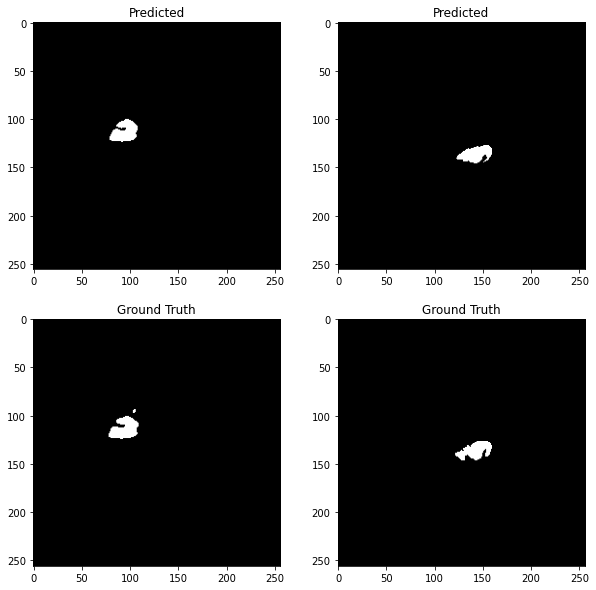

100%|██████████| 993/993 [05:51<00:00,  2.83it/s]


Average Validation Loss: 0.0068038089221018885

Average Validation DSC: [0.99916204 0.89555695 0.89461486 0.83269987]
Average Validation ASSD: [ 0.12239262 14.83237317 14.31665433 10.19085986]
Epoch 22/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


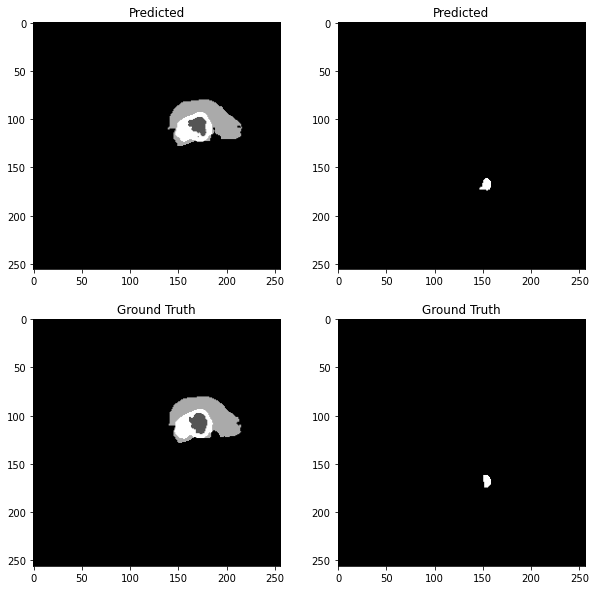

100%|██████████| 3971/3971 [37:25<00:00,  1.77it/s]



Average Training Loss: 0.0044444422344286656

Average Training DSC: [0.99937643 0.91342936 0.93685131 0.87629973]
Average Training ASSD: [ 0.08226207 10.95899151  4.69917311  9.32274139]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


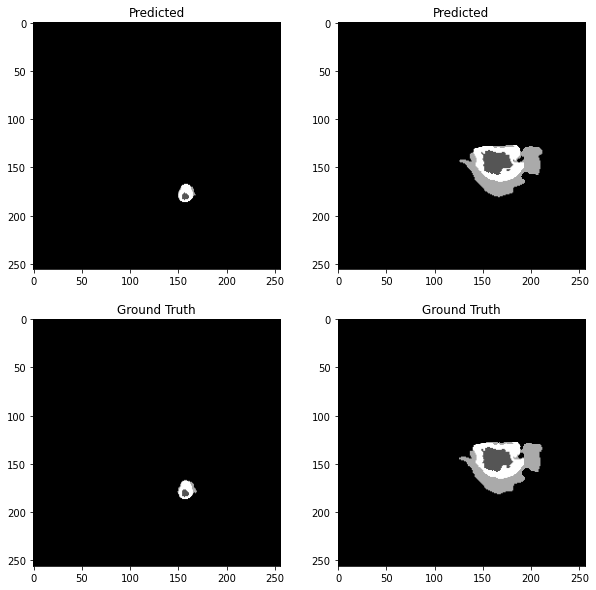

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.006542781523118417

Average Validation DSC: [0.99924422 0.90093584 0.91021151 0.844405  ]
Average Validation ASSD: [ 0.11030864 14.27519824 11.2849522  10.76508908]
Epoch 23/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


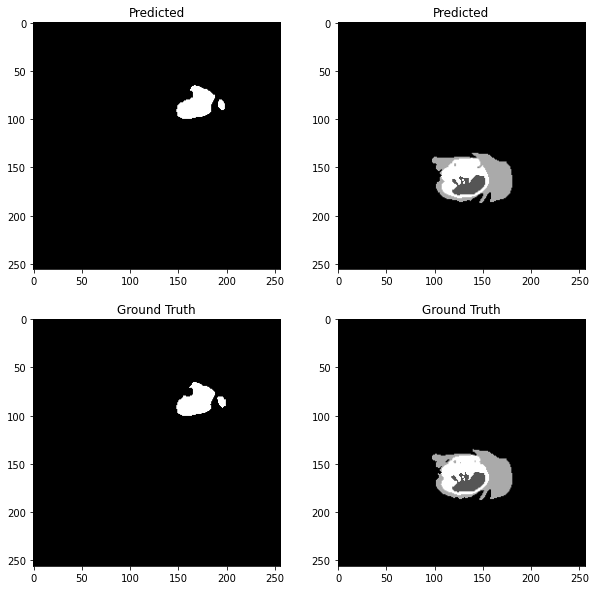

100%|██████████| 3971/3971 [37:22<00:00,  1.77it/s]



Average Training Loss: 0.0042968156887183175

Average Training DSC: [0.99938948 0.91483243 0.93847717 0.87876656]
Average Training ASSD: [ 0.08076357 10.60640467  4.48593898  9.36124195]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


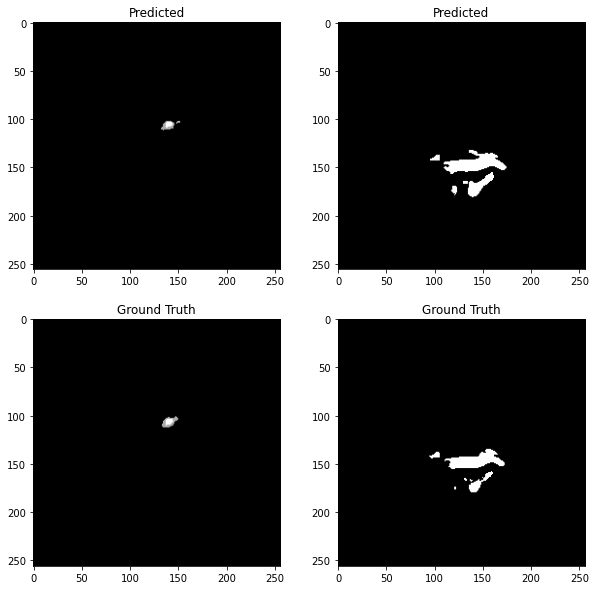

100%|██████████| 993/993 [05:39<00:00,  2.92it/s]


Average Validation Loss: 0.006486232052271114

Average Validation DSC: [0.99926161 0.90064577 0.91011624 0.85184437]
Average Validation ASSD: [ 0.10045395 14.3218041  11.24534759  9.0810871 ]
Epoch 24/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


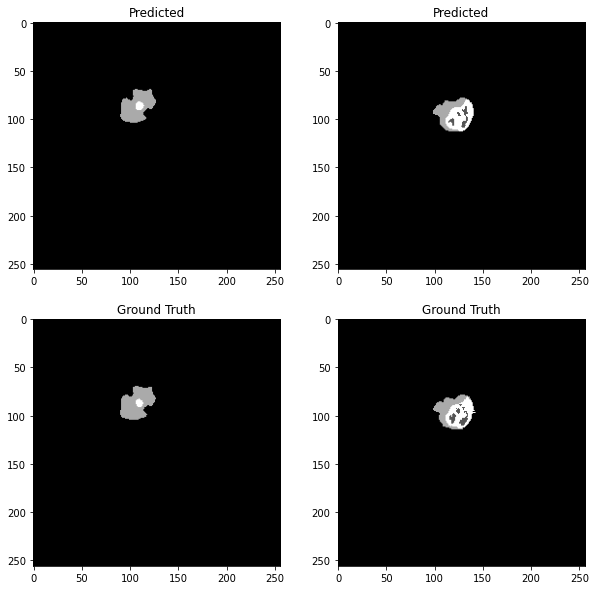

100%|██████████| 3971/3971 [37:07<00:00,  1.78it/s]



Average Training Loss: 0.004257111507866628

Average Training DSC: [0.9993992  0.91595027 0.9395027  0.88044195]
Average Training ASSD: [ 0.07860855 10.47375188  4.47367481  8.91766257]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


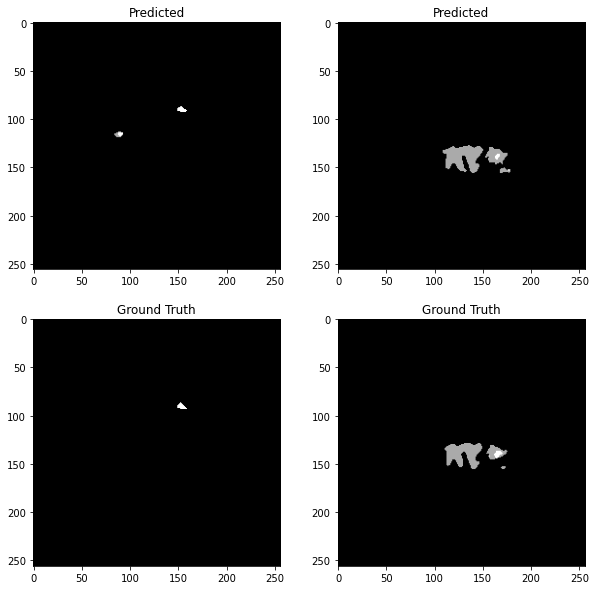

100%|██████████| 993/993 [05:55<00:00,  2.79it/s]


Average Validation Loss: 0.006412862634055564

Average Validation DSC: [0.99925015 0.90285043 0.91132895 0.84824492]
Average Validation ASSD: [ 0.10743812 13.49726752 11.08873818  9.39169271]
Epoch 25/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


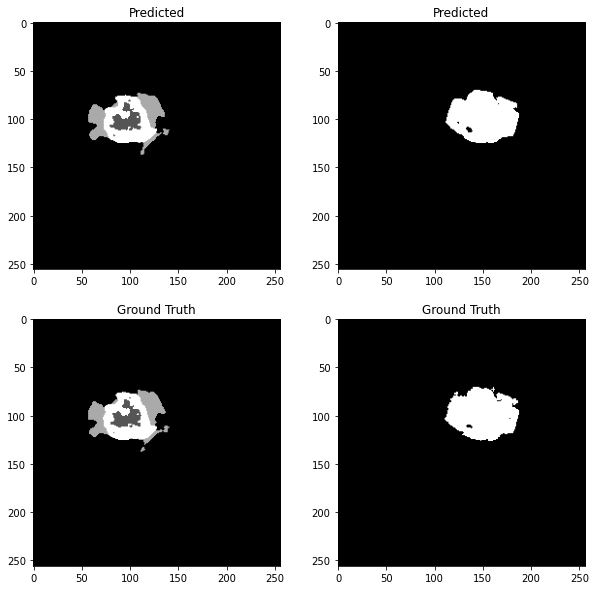

100%|██████████| 3971/3971 [38:05<00:00,  1.74it/s]



Average Training Loss: 0.004076233974027533

Average Training DSC: [0.9994197  0.9180031  0.94267586 0.88544354]
Average Training ASSD: [ 0.074671   10.06102942  3.81154967  8.55563914]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


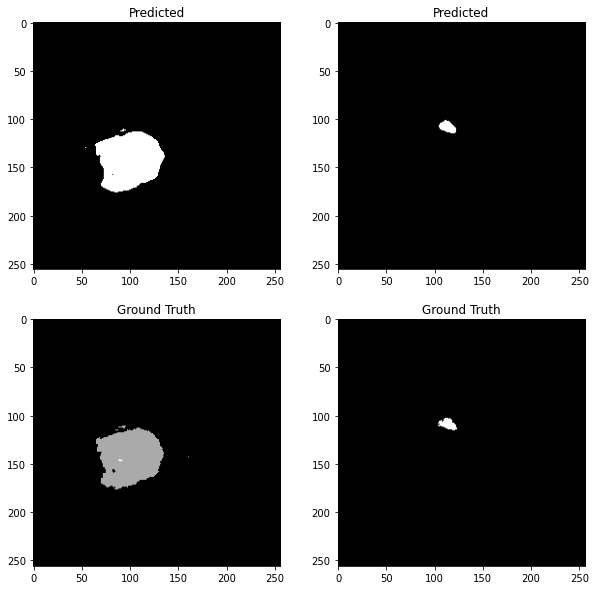

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.006517615238221481

Average Validation DSC: [0.99926878 0.90100256 0.9114748  0.84953737]
Average Validation ASSD: [ 0.10171115 13.94601277 11.322982    9.93274914]
Epoch 26/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


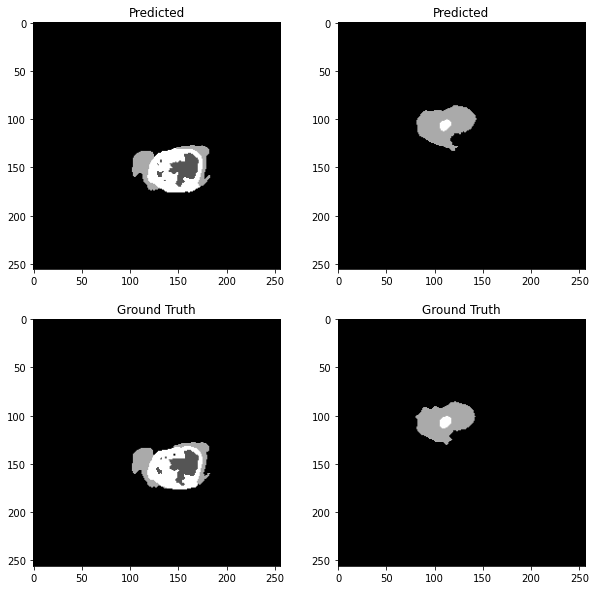

100%|██████████| 3971/3971 [36:47<00:00,  1.80it/s]



Average Training Loss: 0.004025591755089088

Average Training DSC: [0.99943021 0.91908702 0.94334452 0.88617364]
Average Training ASSD: [0.07354349 9.84908946 3.83096914 8.57589687]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


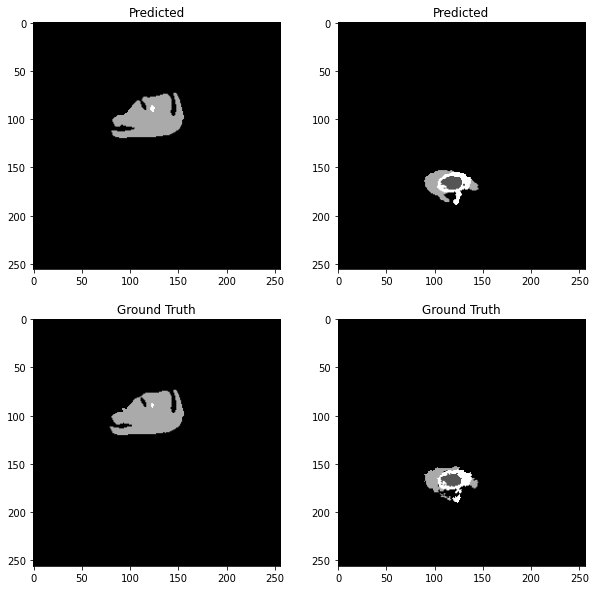

100%|██████████| 993/993 [05:39<00:00,  2.93it/s]


Average Validation Loss: 0.0064808905639564705

Average Validation DSC: [0.99926648 0.9001875  0.91032367 0.84868392]
Average Validation ASSD: [ 0.10208517 13.59958603 11.91324972  9.04471607]
Epoch 27/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


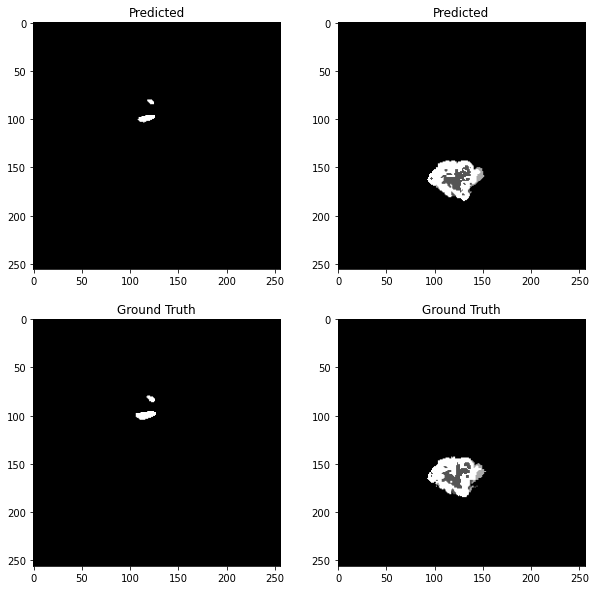

100%|██████████| 3971/3971 [36:47<00:00,  1.80it/s]



Average Training Loss: 0.003881533421166532

Average Training DSC: [0.99944267 0.9209895  0.94549232 0.8897242 ]
Average Training ASSD: [0.07177473 9.58951568 3.48288265 8.46057413]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


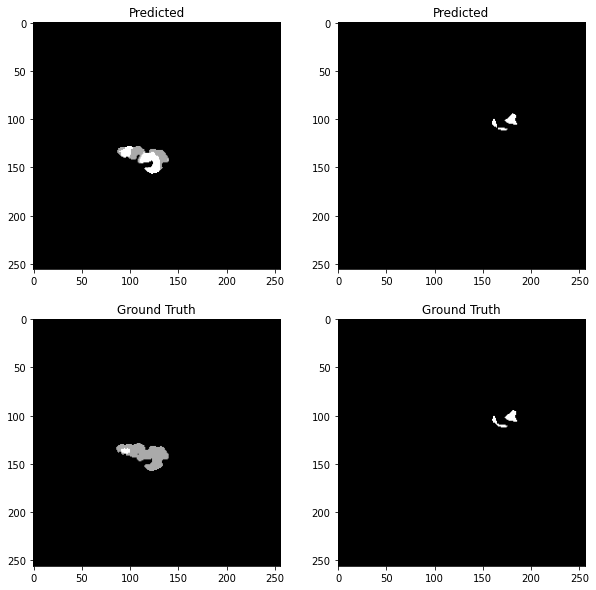

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.0063450259291580975

Average Validation DSC: [0.99927684 0.90486332 0.91048407 0.85273402]
Average Validation ASSD: [ 0.09880716 13.2115494  11.46715694  8.83701851]
Epoch 28/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


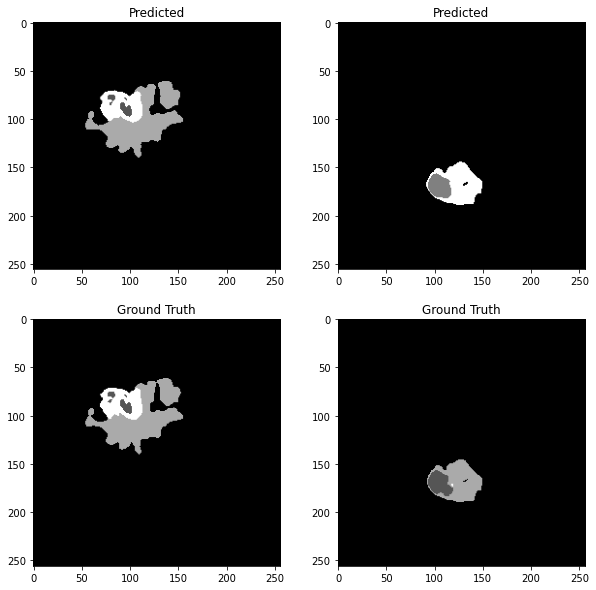

100%|██████████| 3971/3971 [36:48<00:00,  1.80it/s]



Average Training Loss: 0.003748860123169284

Average Training DSC: [0.99946011 0.92285119 0.94769126 0.89213827]
Average Training ASSD: [0.06951966 9.19007044 3.02812981 8.43688688]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


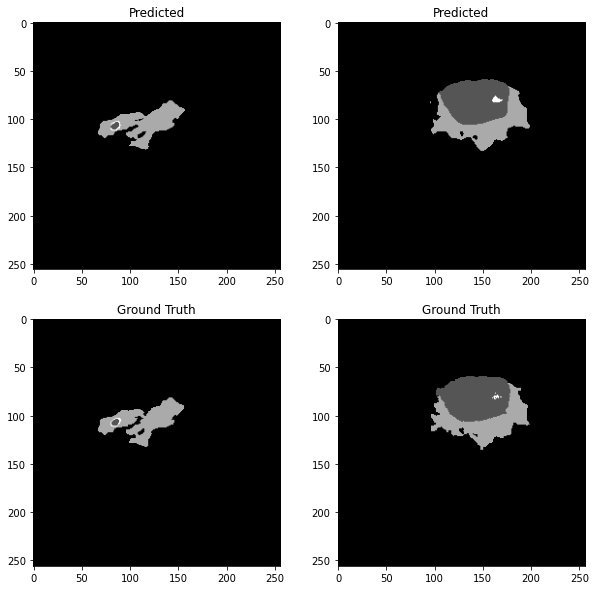

100%|██████████| 993/993 [05:51<00:00,  2.82it/s]


Average Validation Loss: 0.006556805936255739

Average Validation DSC: [0.99927987 0.90427276 0.91022529 0.85427501]
Average Validation ASSD: [ 0.0973578  12.89866656 11.71179673  8.0739243 ]
Epoch 29/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


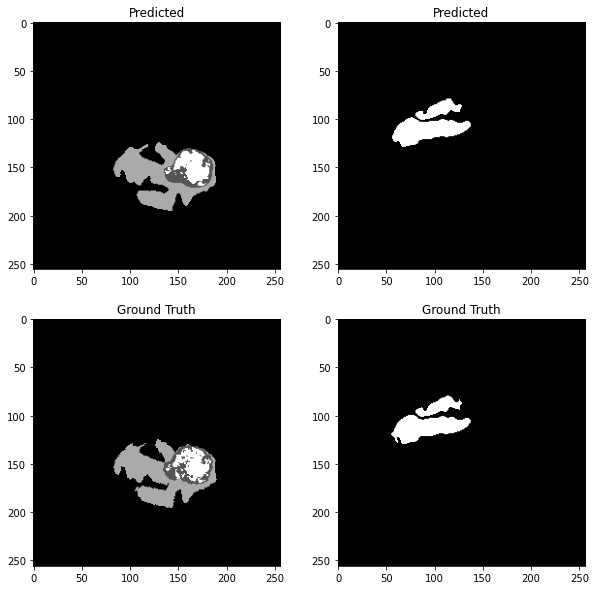

100%|██████████| 3971/3971 [37:26<00:00,  1.77it/s]



Average Training Loss: 0.003722720441695287

Average Training DSC: [0.99946604 0.92311831 0.94804576 0.892669  ]
Average Training ASSD: [0.06745023 9.08582293 3.12558687 8.01655177]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


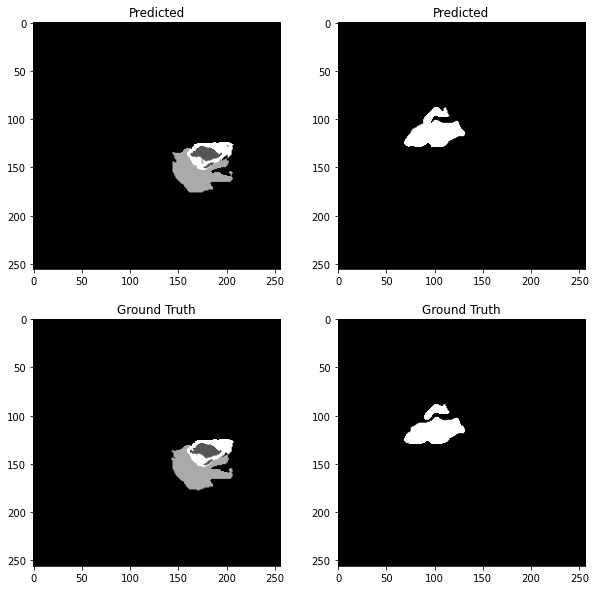

100%|██████████| 993/993 [05:47<00:00,  2.86it/s]


Average Validation Loss: 0.007335642534415992

Average Validation DSC: [0.9991502  0.8918997  0.89953495 0.83809107]
Average Validation ASSD: [ 0.12423214 14.72951049 13.103686    9.90166833]
Epoch 30/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


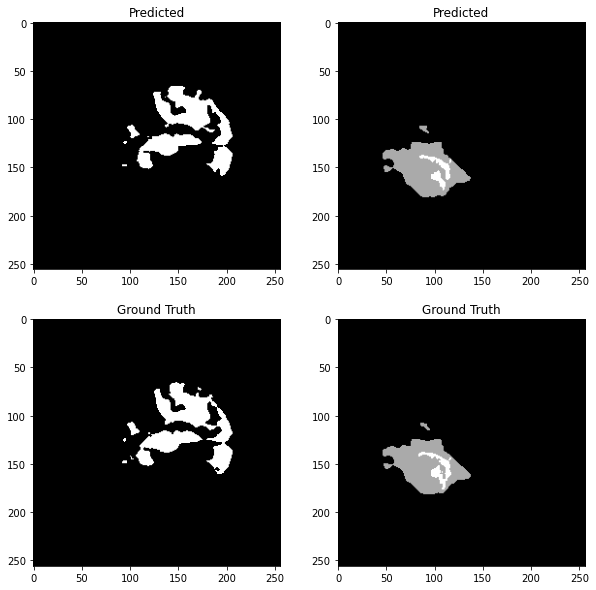

100%|██████████| 3971/3971 [36:47<00:00,  1.80it/s]



Average Training Loss: 0.0036996978543111523

Average Training DSC: [0.99947443 0.92406177 0.94894987 0.89436658]
Average Training ASSD: [0.06654816 8.81769136 3.01295227 8.03370462]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


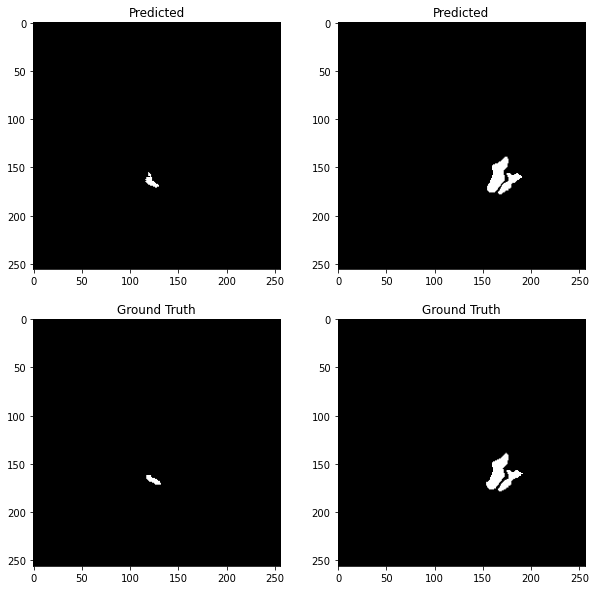

100%|██████████| 993/993 [05:38<00:00,  2.93it/s]


Average Validation Loss: 0.006421212603085771

Average Validation DSC: [0.99930582 0.90606658 0.91293899 0.8591184 ]
Average Validation ASSD: [ 0.09169173 13.16149599 11.33712444  7.07819656]
Epoch 31/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


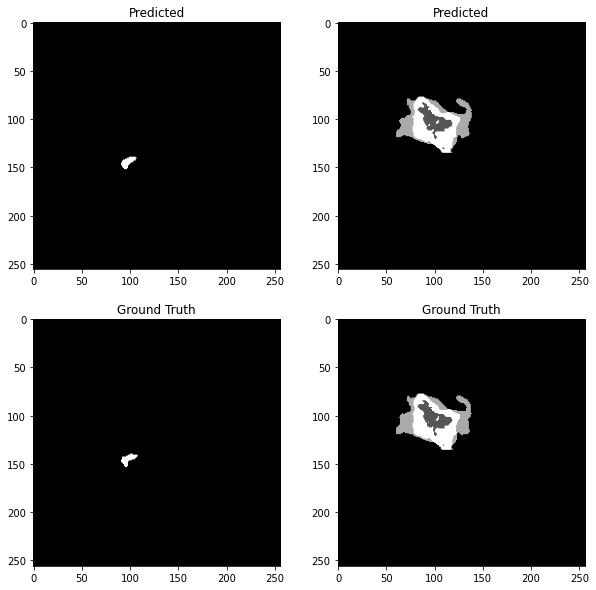

100%|██████████| 3971/3971 [37:01<00:00,  1.79it/s]



Average Training Loss: 0.003506134789227385

Average Training DSC: [0.99949525 0.92642277 0.95185344 0.89863044]
Average Training ASSD: [0.06322682 8.47013516 2.55109462 7.72592709]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


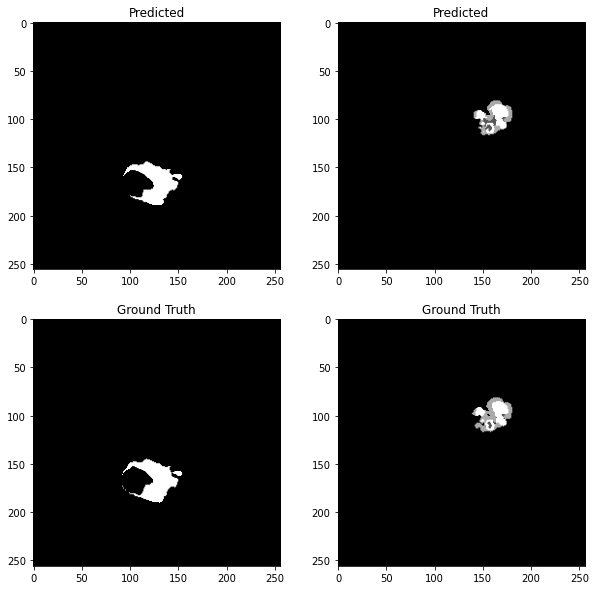

100%|██████████| 993/993 [05:48<00:00,  2.85it/s]


Average Validation Loss: 0.0067173018962452475

Average Validation DSC: [0.99929371 0.90696695 0.9137435  0.85680848]
Average Validation ASSD: [ 0.09549469 12.73391191 10.66951132  9.10800341]
Epoch 32/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


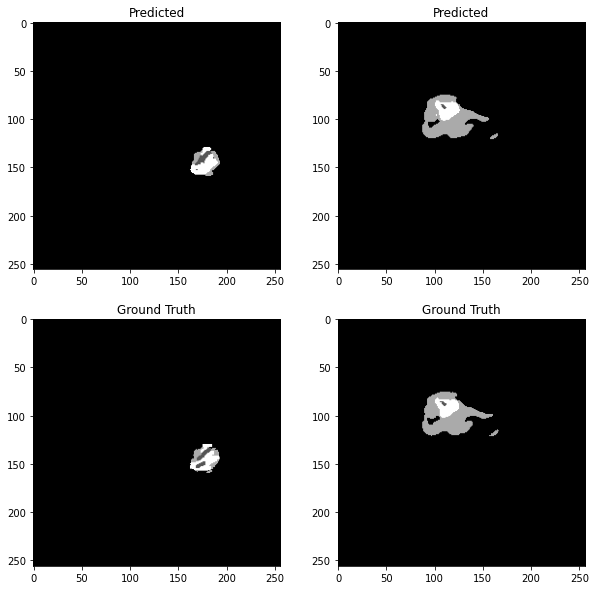

100%|██████████| 3971/3971 [37:55<00:00,  1.74it/s]



Average Training Loss: 0.003534332440239177

Average Training DSC: [0.99949569 0.92602282 0.9503927  0.89789961]
Average Training ASSD: [0.06337315 8.65842719 3.03269585 7.81992635]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


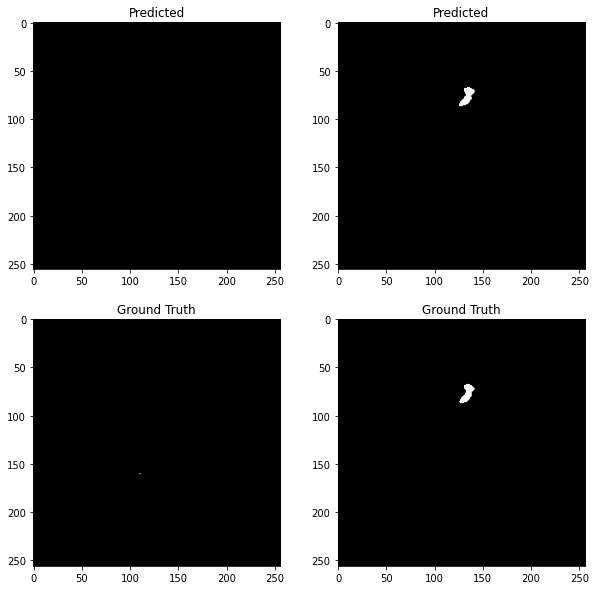

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.006887051159392176

Average Validation DSC: [0.99918164 0.89685155 0.89473833 0.83529739]
Average Validation ASSD: [ 0.12784971 14.01422768 15.16544857  9.29919603]
Epoch 33/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


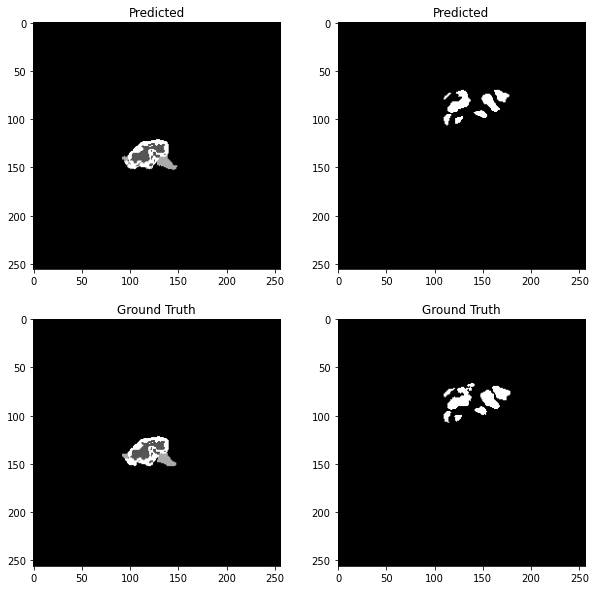

100%|██████████| 3971/3971 [37:30<00:00,  1.76it/s]



Average Training Loss: 0.0034183000622599103

Average Training DSC: [0.99950945 0.9281733  0.95239476 0.90075882]
Average Training ASSD: [0.0611154  8.15341421 2.63501203 7.54766468]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


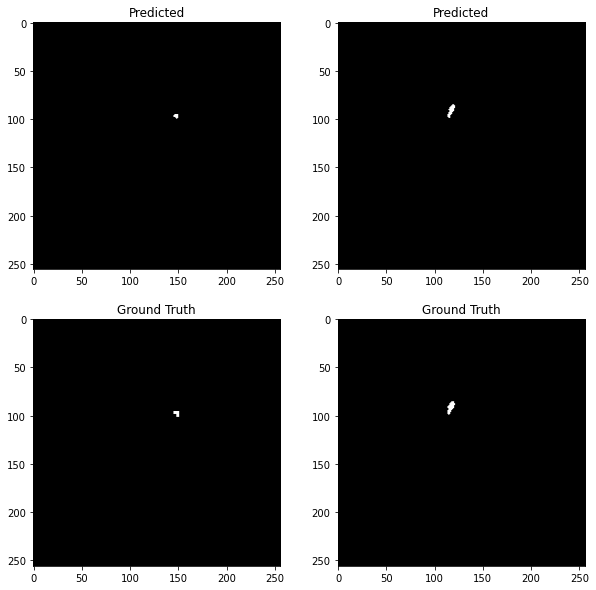

100%|██████████| 993/993 [05:45<00:00,  2.87it/s]


Average Validation Loss: 0.006491205348114578

Average Validation DSC: [0.99932721 0.90876348 0.91632173 0.86041709]
Average Validation ASSD: [ 0.09016976 12.63548712 10.87869373  7.14921855]
Epoch 34/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


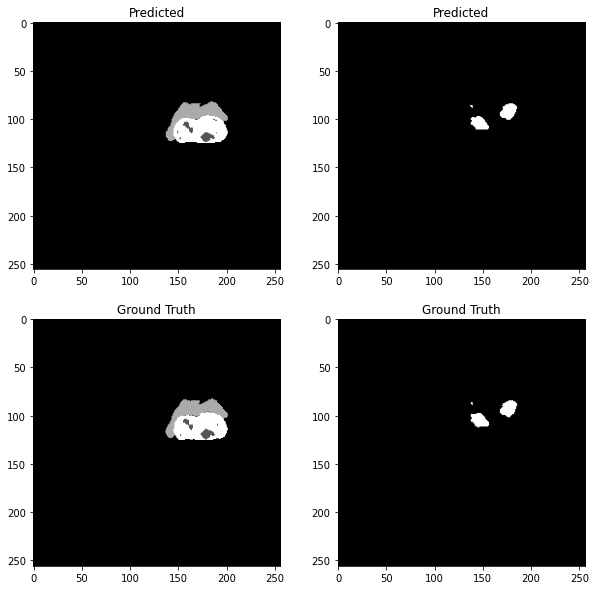

100%|██████████| 3971/3971 [37:23<00:00,  1.77it/s]



Average Training Loss: 0.0034000151164773913

Average Training DSC: [0.99951641 0.92883323 0.95245249 0.90095641]
Average Training ASSD: [0.06070509 7.91864211 2.82076857 7.6639261 ]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


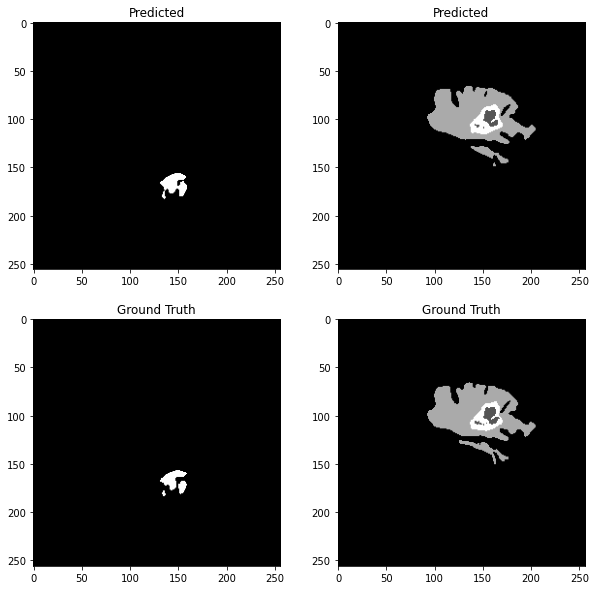

100%|██████████| 993/993 [05:46<00:00,  2.87it/s]


Average Validation Loss: 0.006430122742948965

Average Validation DSC: [0.99930773 0.90735991 0.91580317 0.85747943]
Average Validation ASSD: [ 0.09310411 12.93254096 10.72688931  6.6941244 ]
Epoch 35/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


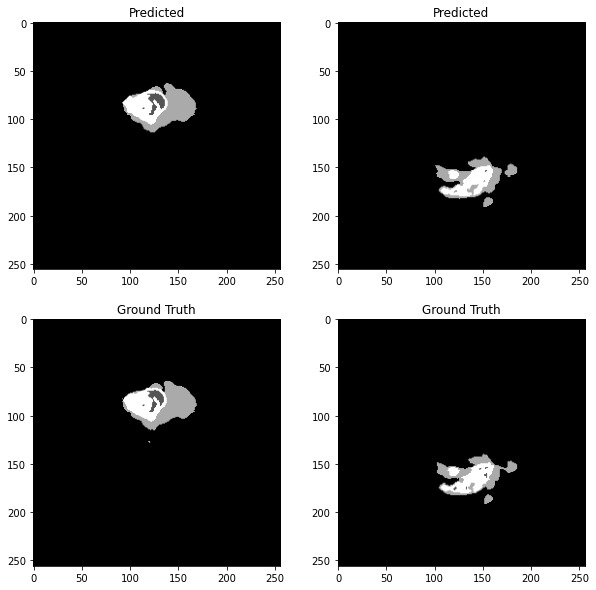

100%|██████████| 3971/3971 [37:14<00:00,  1.78it/s]



Average Training Loss: 0.0033868997256292412

Average Training DSC: [0.99952128 0.92880904 0.95344116 0.90238696]
Average Training ASSD: [0.05957837 8.2260581  2.65193155 7.17784272]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


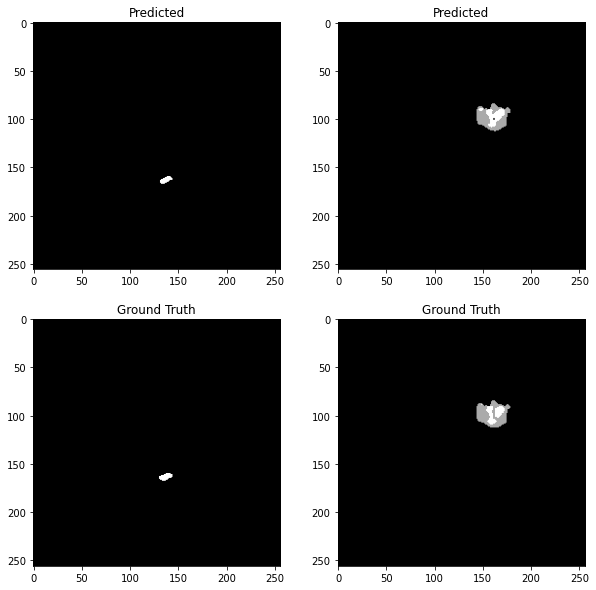

100%|██████████| 993/993 [05:44<00:00,  2.88it/s]


Average Validation Loss: 0.006255830487814119

Average Validation DSC: [0.99930277 0.90810532 0.91210027 0.8580929 ]
Average Validation ASSD: [ 0.09556358 12.54701104 12.0328493   7.91713642]
Epoch 36/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


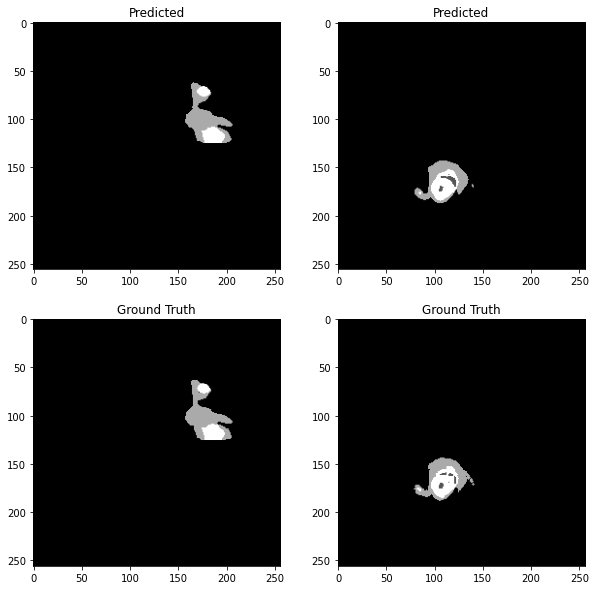

100%|██████████| 3971/3971 [37:06<00:00,  1.78it/s]



Average Training Loss: 0.003353577877625399

Average Training DSC: [0.99952704 0.9301525  0.95319594 0.90344263]
Average Training ASSD: [0.05888209 7.83779831 2.82565124 7.33912695]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


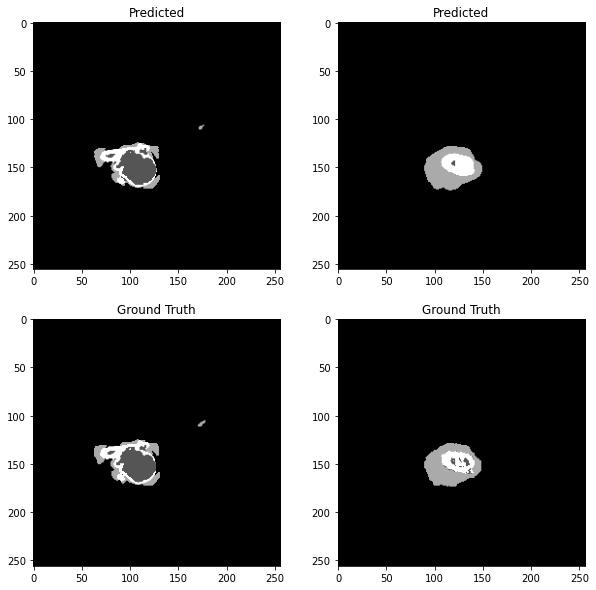

100%|██████████| 993/993 [05:48<00:00,  2.85it/s]


Average Validation Loss: 0.006187325876678855

Average Validation DSC: [0.99931455 0.90766912 0.91543774 0.86240189]
Average Validation ASSD: [ 0.09087472 12.39617187 10.94483246  6.34714393]
Epoch 37/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


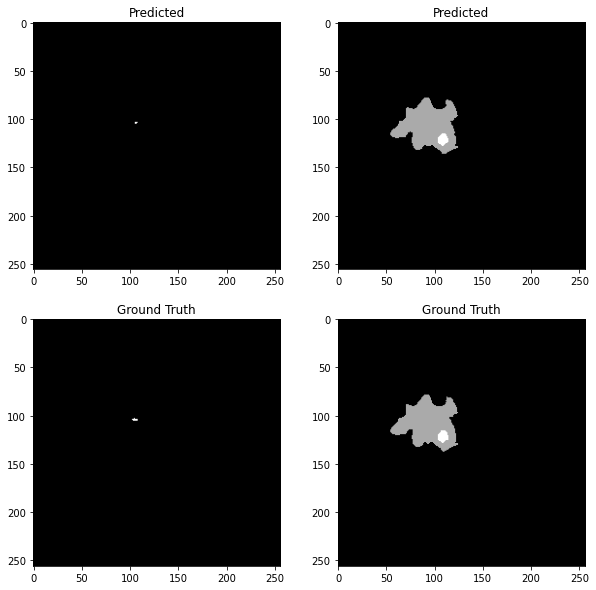

100%|██████████| 3971/3971 [37:05<00:00,  1.78it/s]



Average Training Loss: 0.003230430522200224

Average Training DSC: [0.99954219 0.9310465  0.95570126 0.90610747]
Average Training ASSD: [0.056746   7.71590045 2.36139442 7.11634458]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


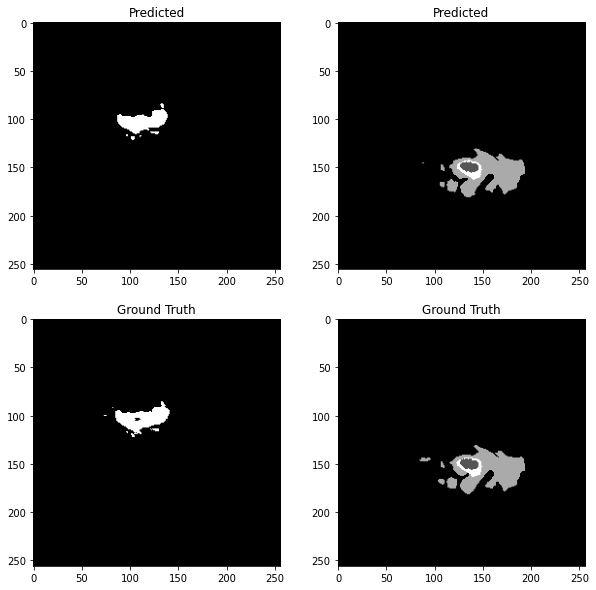

100%|██████████| 993/993 [05:49<00:00,  2.84it/s]


Average Validation Loss: 0.006678667451721154

Average Validation DSC: [0.99925232 0.89935465 0.90695339 0.8512073 ]
Average Validation ASSD: [ 0.10563109 14.29507707 12.4752577   8.05125525]
Epoch 38/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


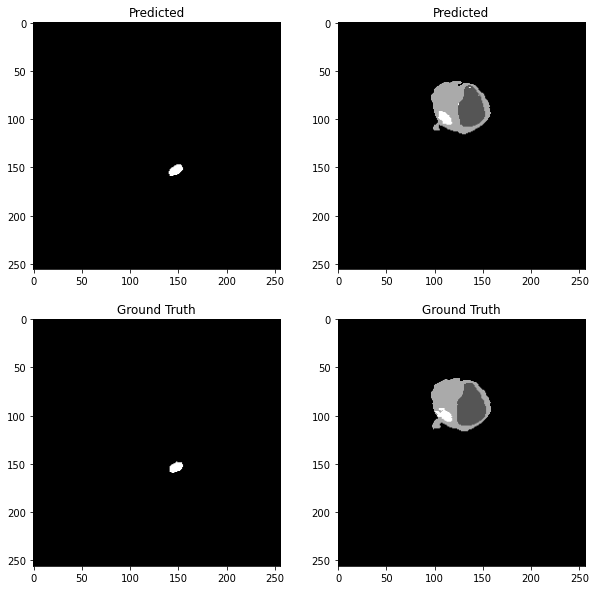

100%|██████████| 3971/3971 [37:02<00:00,  1.79it/s]



Average Training Loss: 0.003104820266050326

Average Training DSC: [0.99955364 0.93292867 0.95702565 0.90885751]
Average Training ASSD: [0.05457721 7.28661306 2.15532031 6.71845364]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


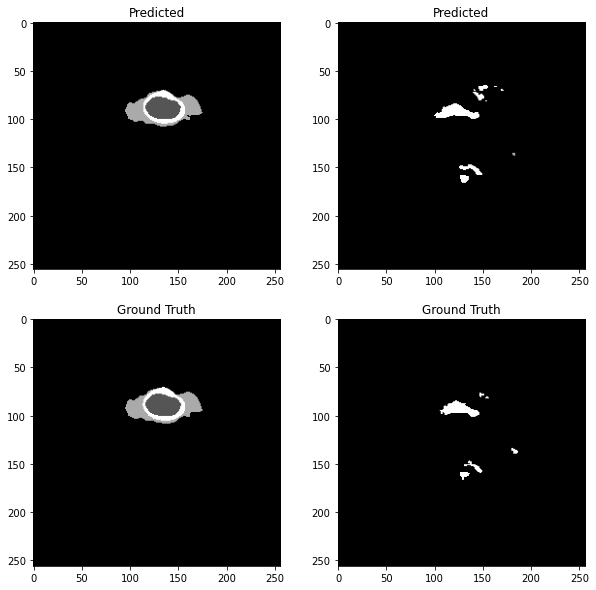

100%|██████████| 993/993 [05:47<00:00,  2.86it/s]


Average Validation Loss: 0.006397483327818991

Average Validation DSC: [0.99930884 0.90851875 0.91335511 0.85667059]
Average Validation ASSD: [ 0.09458638 12.54195987 11.26738052  8.7696008 ]
Epoch 39/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


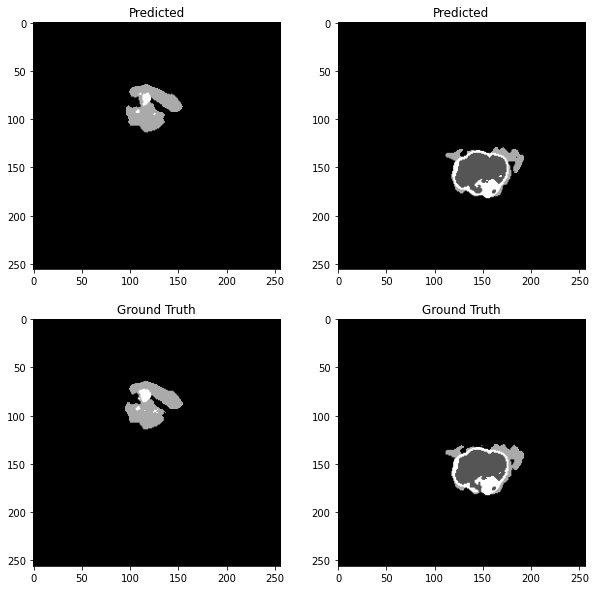

100%|██████████| 3971/3971 [37:14<00:00,  1.78it/s]



Average Training Loss: 0.003067248237358692

Average Training DSC: [0.99956028 0.9334159  0.95797552 0.90990363]
Average Training ASSD: [0.05407223 7.27804839 1.95852154 6.93077516]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


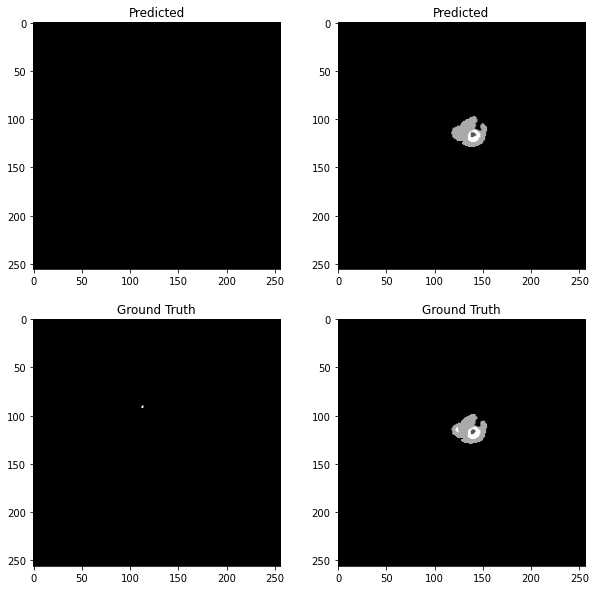

100%|██████████| 993/993 [05:41<00:00,  2.91it/s]


Average Validation Loss: 0.006312223007594876

Average Validation DSC: [0.9993471  0.91049108 0.91990892 0.86604338]
Average Validation ASSD: [ 0.08578664 12.30109375 10.23958858  6.34342812]
Epoch 40/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


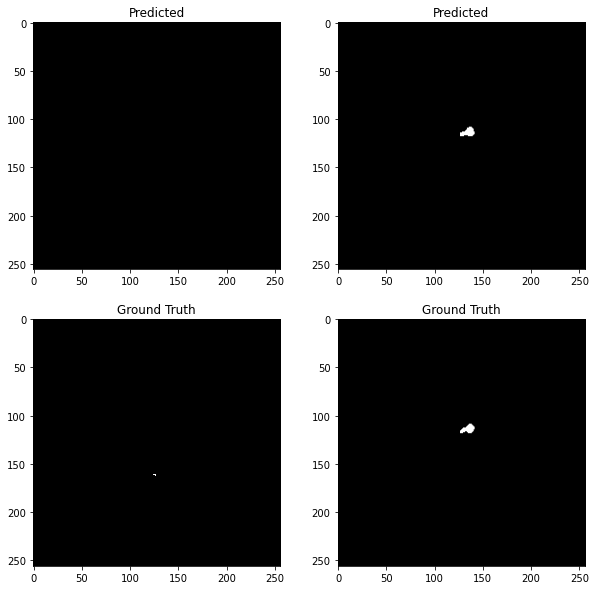

100%|██████████| 3971/3971 [36:59<00:00,  1.79it/s]



Average Training Loss: 0.0029827939118116766

Average Training DSC: [0.99956912 0.93503898 0.95901352 0.91163152]
Average Training ASSD: [0.0529842  7.00782404 1.78229342 6.75407942]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


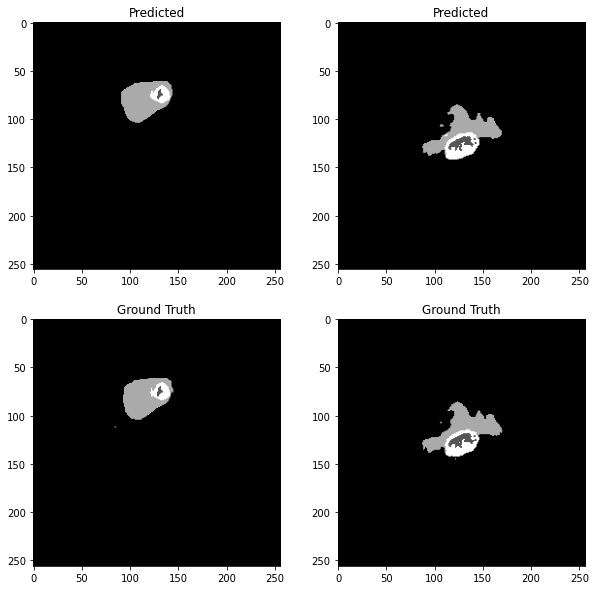

100%|██████████| 993/993 [05:50<00:00,  2.84it/s]


Average Validation Loss: 0.006746822492616234

Average Validation DSC: [0.99933613 0.90977711 0.91824122 0.86565203]
Average Validation ASSD: [ 0.08745986 12.59323733 10.5848362   5.97219027]
Epoch 41/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


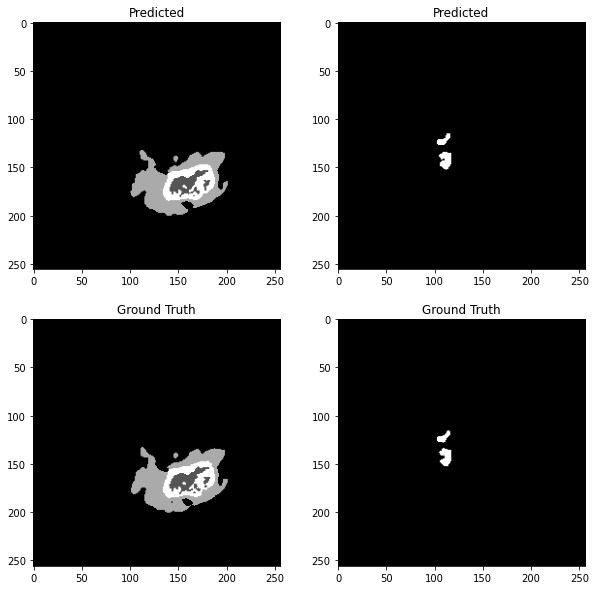

100%|██████████| 3971/3971 [37:41<00:00,  1.76it/s]



Average Training Loss: 0.0030403248776942754

Average Training DSC: [0.99956487 0.93375917 0.95745973 0.91013726]
Average Training ASSD: [0.05403843 7.19388523 2.30250267 6.89056484]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


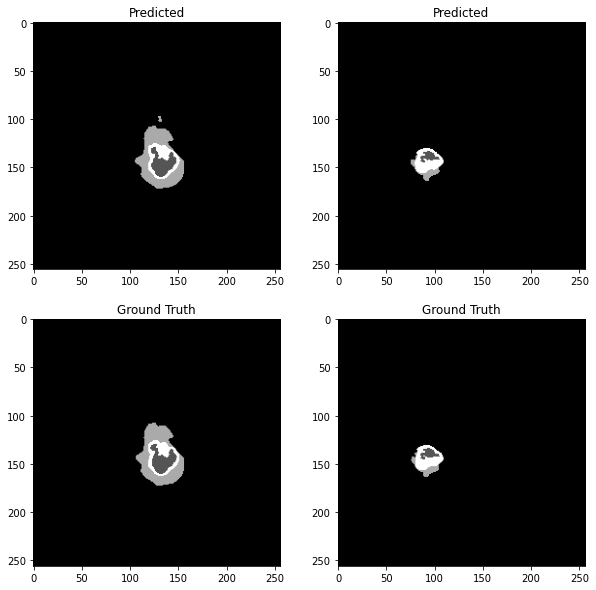

100%|██████████| 993/993 [05:45<00:00,  2.88it/s]


Average Validation Loss: 0.006568098881573595

Average Validation DSC: [0.99932597 0.90864066 0.91662495 0.8593952 ]
Average Validation ASSD: [ 0.09106773 12.47633496 10.73385879  7.23672015]
Epoch 42/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


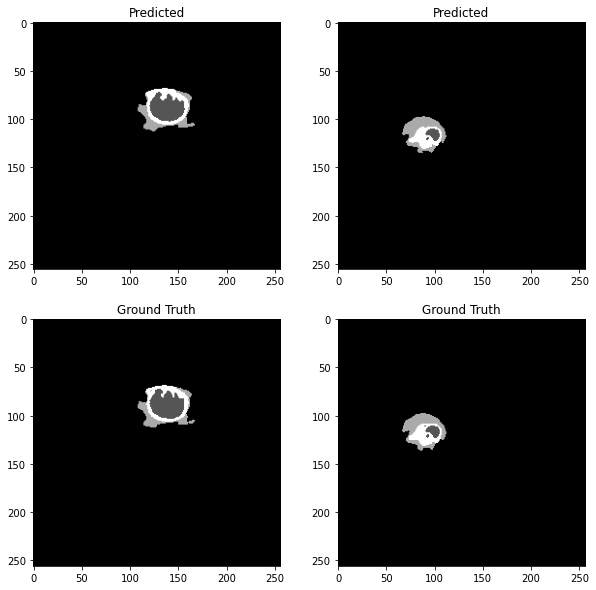

100%|██████████| 3971/3971 [37:04<00:00,  1.79it/s]



Average Training Loss: 0.00300864389333222

Average Training DSC: [0.99957224 0.93494155 0.9582551  0.9109972 ]
Average Training ASSD: [0.05279506 7.03484791 2.2209863  6.52378978]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


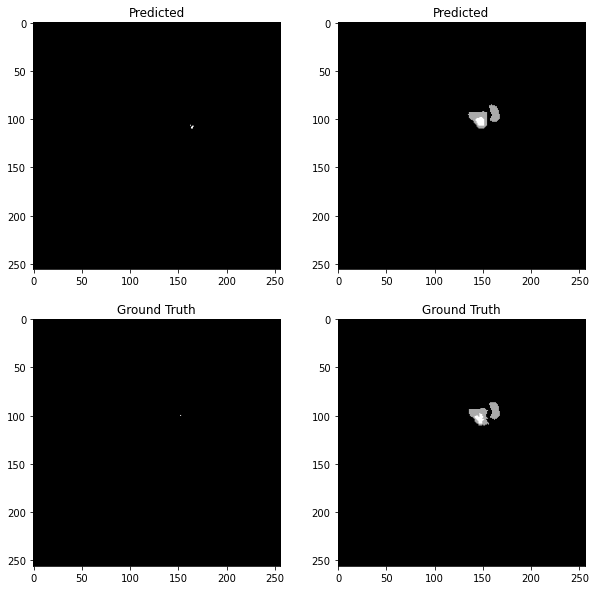

100%|██████████| 993/993 [05:53<00:00,  2.81it/s]


Average Validation Loss: 0.006483671352715575

Average Validation DSC: [0.99935288 0.91110725 0.9208316  0.86548263]
Average Validation ASSD: [ 0.08551769 12.39757228  9.98415045  6.55475706]
Epoch 43/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


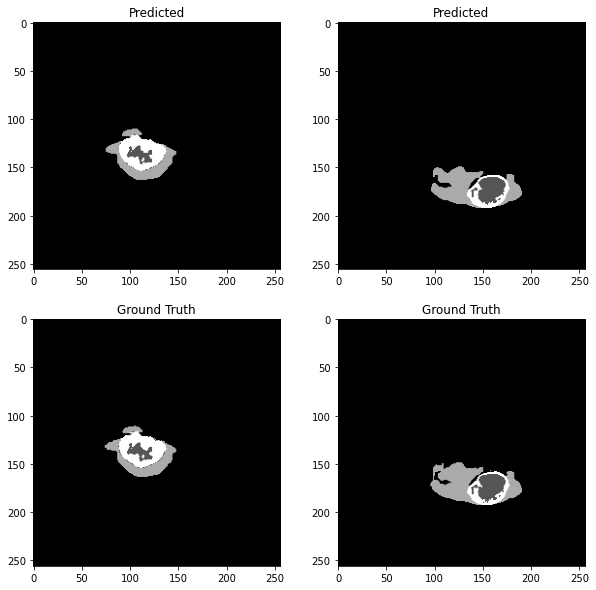

100%|██████████| 3971/3971 [37:57<00:00,  1.74it/s]



Average Training Loss: 0.002864128963624741

Average Training DSC: [0.99959103 0.93664742 0.96018595 0.91476217]
Average Training ASSD: [0.04980791 6.76757568 1.98780092 6.50181331]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


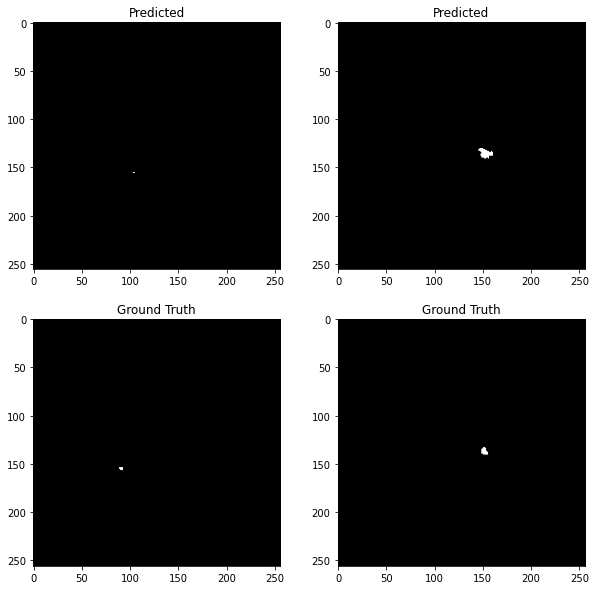

100%|██████████| 993/993 [05:54<00:00,  2.80it/s]


Average Validation Loss: 0.006979402221977515

Average Validation DSC: [0.99933501 0.91025686 0.91780131 0.86233039]
Average Validation ASSD: [ 0.08900466 12.19510552 10.69193273  7.54437421]
Epoch 44/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


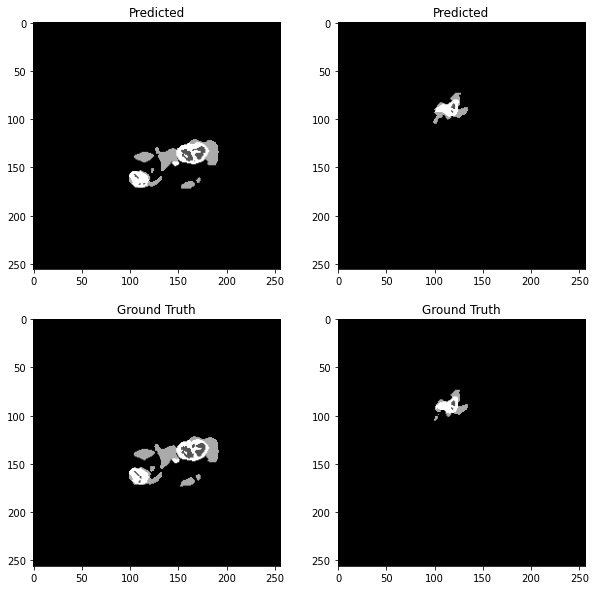

100%|██████████| 3971/3971 [38:01<00:00,  1.74it/s]



Average Training Loss: 0.0028955250378011874

Average Training DSC: [0.99958944 0.93717703 0.95938431 0.91398867]
Average Training ASSD: [0.05005736 6.57079407 2.21173063 6.39002878]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


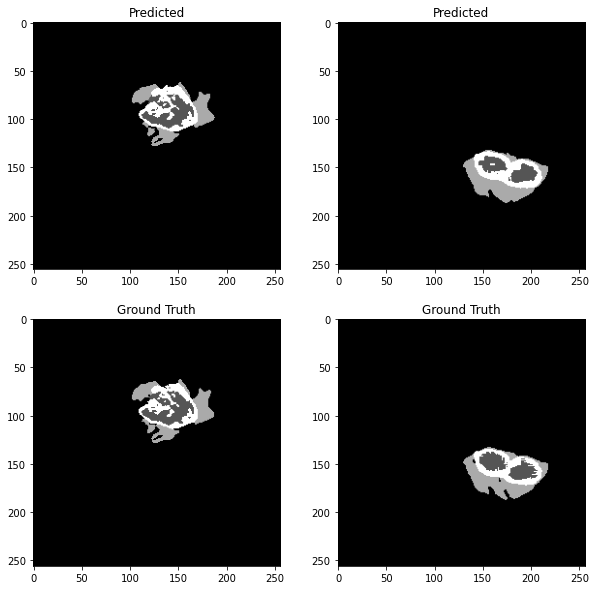

100%|██████████| 993/993 [05:48<00:00,  2.85it/s]


Average Validation Loss: 0.006619062715149996

Average Validation DSC: [0.99935423 0.91192616 0.92004142 0.8675601 ]
Average Validation ASSD: [ 0.08483416 12.33741682 10.33152381  6.36107928]
Epoch 45/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


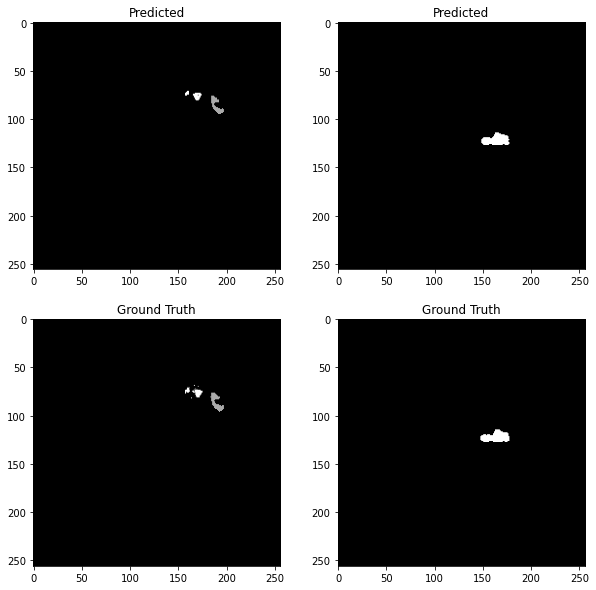

100%|██████████| 3971/3971 [37:04<00:00,  1.79it/s]



Average Training Loss: 0.0027456586605659797

Average Training DSC: [0.99960538 0.93865896 0.96211332 0.91767942]
Average Training ASSD: [0.04800663 6.35614209 1.68850552 6.28010978]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


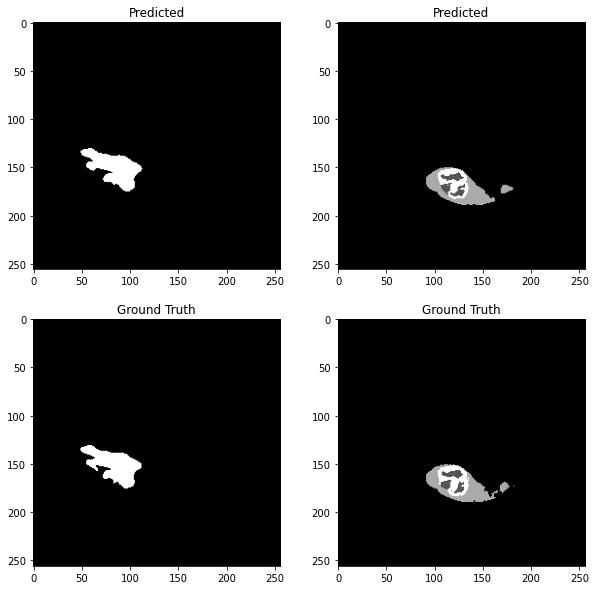

100%|██████████| 993/993 [05:40<00:00,  2.91it/s]


Average Validation Loss: 0.006598152963290777

Average Validation DSC: [0.99936028 0.91199646 0.92171    0.86742745]
Average Validation ASSD: [ 0.08515352 12.0425713  10.13075244  6.1895558 ]
Epoch 46/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


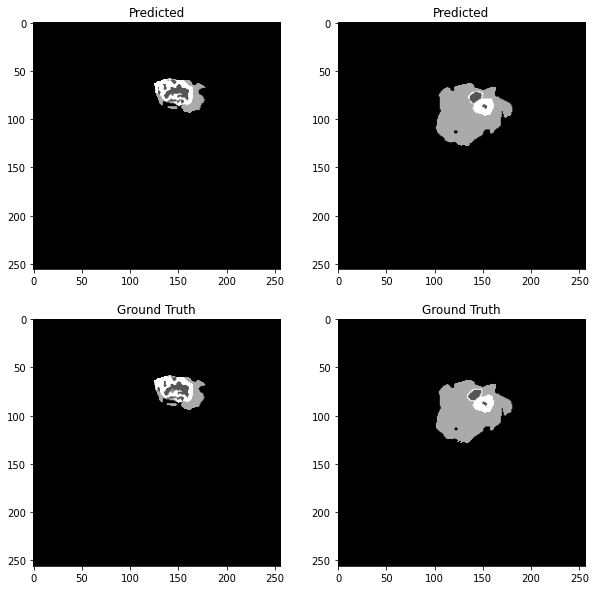

100%|██████████| 3971/3971 [36:58<00:00,  1.79it/s]



Average Training Loss: 0.002758089543510912

Average Training DSC: [0.99960438 0.9386088  0.96220314 0.91819639]
Average Training ASSD: [0.0477508  6.33530717 1.68382779 6.15888344]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


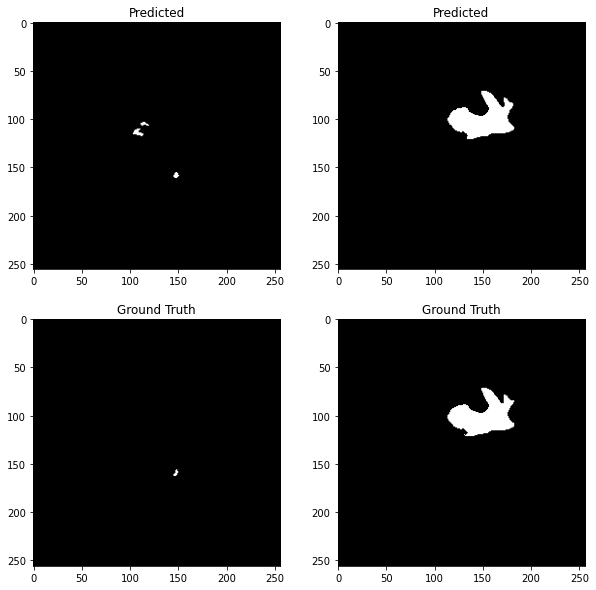

100%|██████████| 993/993 [05:48<00:00,  2.85it/s]


Average Validation Loss: 0.006364692379096814

Average Validation DSC: [0.99934235 0.91001758 0.91748274 0.86611798]
Average Validation ASSD: [ 0.087333   12.21884449 10.59059054  5.99934726]
Epoch 47/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


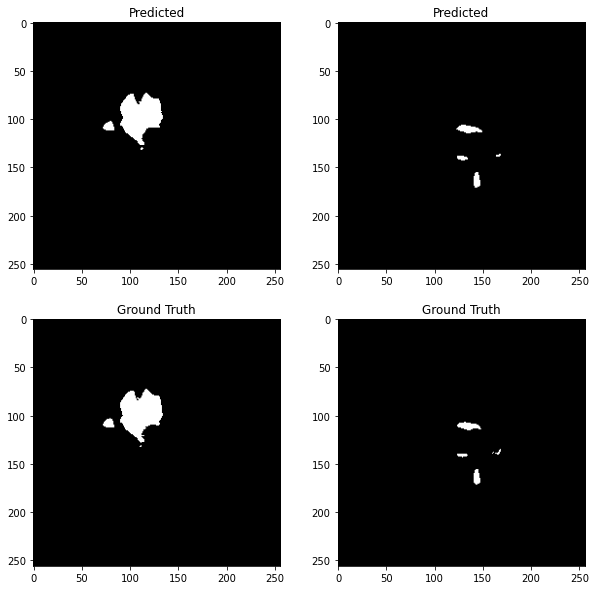

100%|██████████| 3971/3971 [37:30<00:00,  1.76it/s]



Average Training Loss: 0.0026563419167431285

Average Training DSC: [0.99961701 0.94033961 0.9634291  0.92018906]
Average Training ASSD: [0.04610612 6.06276828 1.51837124 5.99639702]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


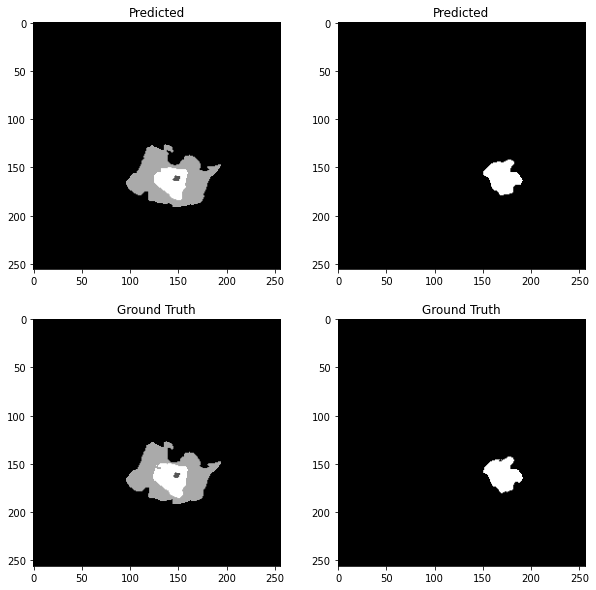

100%|██████████| 993/993 [05:41<00:00,  2.91it/s]


Average Validation Loss: 0.006829105439986978

Average Validation DSC: [0.99929586 0.90445634 0.89504535 0.85007878]
Average Validation ASSD: [ 0.09745674 13.46692997 18.14902353  8.47444018]
Epoch 48/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


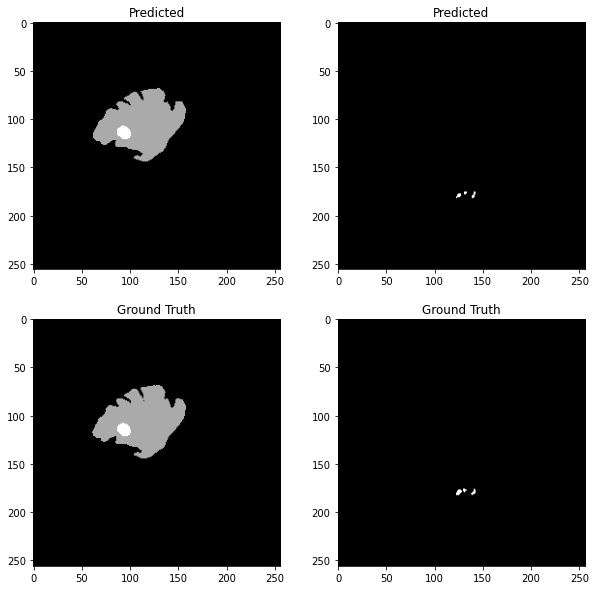

100%|██████████| 3971/3971 [36:49<00:00,  1.80it/s]



Average Training Loss: 0.0026578660459836718

Average Training DSC: [0.99961846 0.94010559 0.96311335 0.9199262 ]
Average Training ASSD: [0.04631204 6.1898197  1.65351456 6.00010514]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


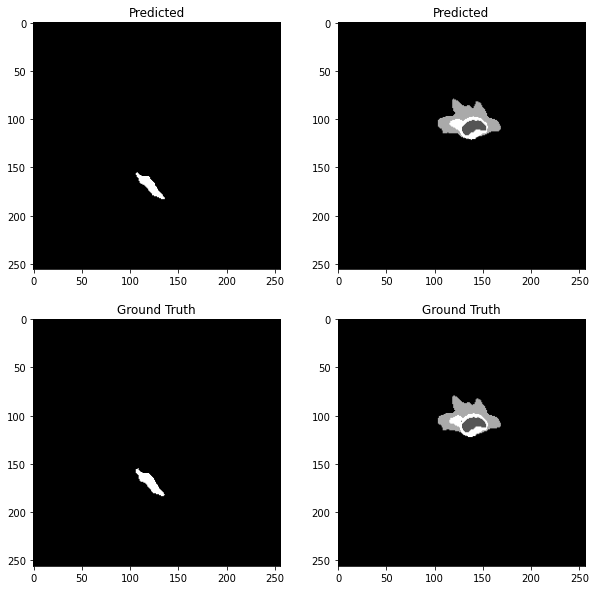

100%|██████████| 993/993 [05:46<00:00,  2.86it/s]


Average Validation Loss: 0.006638168847124577

Average Validation DSC: [0.99936128 0.91281619 0.92146348 0.86920915]
Average Validation ASSD: [ 0.08358929 11.92711941 10.06840816  5.6306431 ]
Epoch 49/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


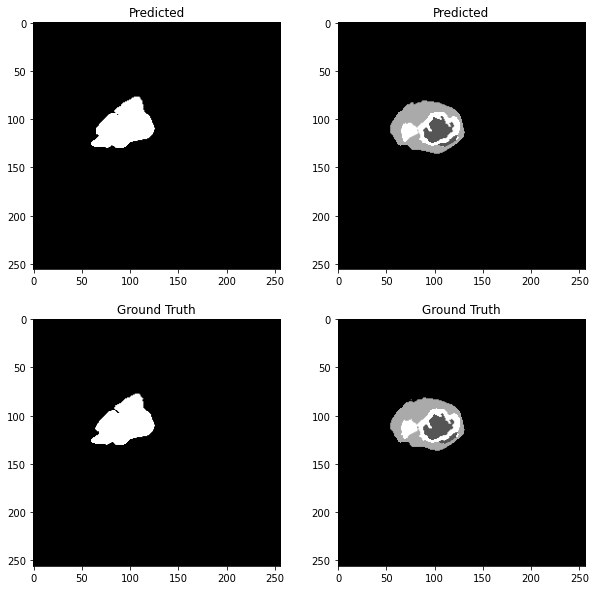

100%|██████████| 3971/3971 [37:27<00:00,  1.77it/s]



Average Training Loss: 0.002587340167355148

Average Training DSC: [0.99962786 0.94088351 0.9645007  0.92189458]
Average Training ASSD: [0.04475988 6.06688129 1.46158886 5.90909767]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


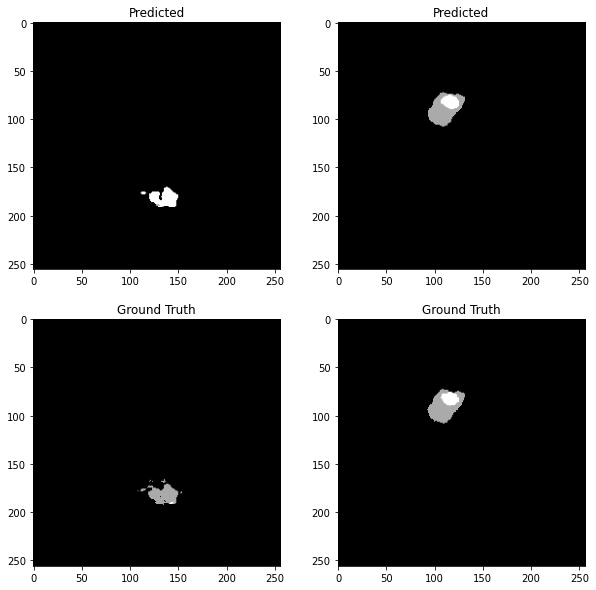

100%|██████████| 993/993 [05:41<00:00,  2.90it/s]


Average Validation Loss: 0.006883466472072679

Average Validation DSC: [0.99936172 0.9114891  0.92123665 0.86834111]
Average Validation ASSD: [ 0.08411406 12.10814414 10.14242313  5.81835316]
Epoch 50/50
-------------------------


  0%|          | 0/3971 [00:00<?, ?it/s]

Training Prediction Visualization:


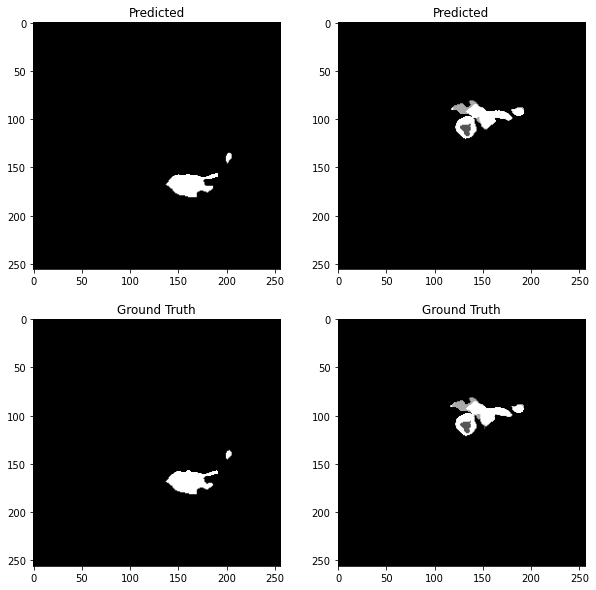

100%|██████████| 3971/3971 [37:06<00:00,  1.78it/s]



Average Training Loss: 0.002581209894786846

Average Training DSC: [0.99963166 0.9413839  0.96420408 0.92234727]
Average Training ASSD: [0.04457569 5.97318079 1.63494512 5.87236906]


  0%|          | 0/993 [00:00<?, ?it/s]

Validation Prediction Visualization:


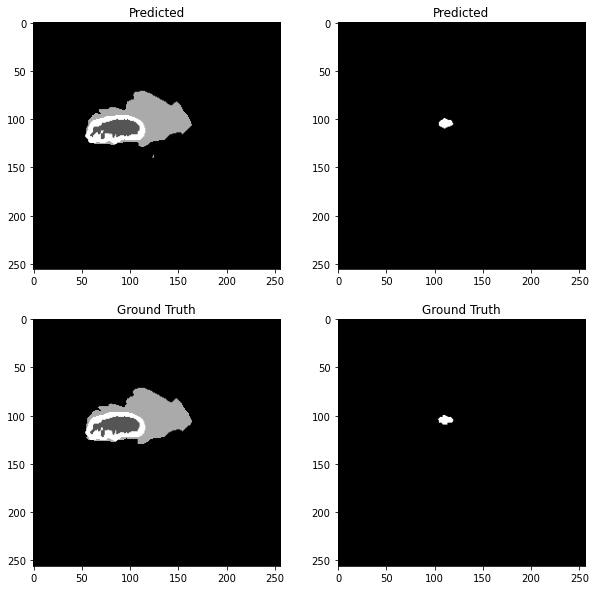

100%|██████████| 993/993 [05:43<00:00,  2.89it/s]


Average Validation Loss: 0.006203870182811899

Average Validation DSC: [0.99933794 0.90862497 0.91498654 0.86260915]
Average Validation ASSD: [ 0.08991436 13.14552727 11.19505774  6.67596852]


In [23]:
model = train_model(num_epochs = 50)